In [1]:
!gdown --id 1h9T0_jsGZSpbY3r9ZXAs10iVtHlK2QF0

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1h9T0_jsGZSpbY3r9ZXAs10iVtHlK2QF0
From (redirected): https://drive.google.com/uc?id=1h9T0_jsGZSpbY3r9ZXAs10iVtHlK2QF0&confirm=t&uuid=1145da23-7e08-4675-8415-3024031c4096
To: /content/mirflickr25k.zip
100% 3.07G/3.07G [00:16<00:00, 186MB/s]


In [2]:
import zipfile
import os

with zipfile.ZipFile('/content/mirflickr25k.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [7]:
# # https://youtu.be/nbRkLE2fiVI
# https://youtu.be/1HqjPqNglPc
"""


Dataset from: http://press.liacs.nl/mirflickr/mirdownload.html

Read high res. original images and save lower versions to be used for SRGAN.

Here, we are resizing them to 128x128 that will be  used as HR images and
32x32 that will be used as LR images
"""

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

train_dir = "/content/data/mirflickr"



for img in os.listdir(train_dir):
    img_array = cv2.imread(train_dir+"/"+img)
    if  img_array is None:
        continue
    img_array = cv2.resize(img_array, (128,128))
    lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)


In [8]:
# https://youtu.be/nbRkLE2fiVI
# https://youtu.be/1HqjPqNglPc
"""
Single Image Super-Resolution Using SRGAN

Original paper: https://arxiv.org/pdf/1609.04802.pdf

Dataset from:
    http://press.liacs.nl/mirflickr/mirdownload.html

All images resized to 128x128 to represent HR and 32x32 to represent LR.

"""


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm



In [9]:
#########################################################################

#Define blocks to build the generator
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


#VGG19
#We need VGG19 for the feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer.
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.



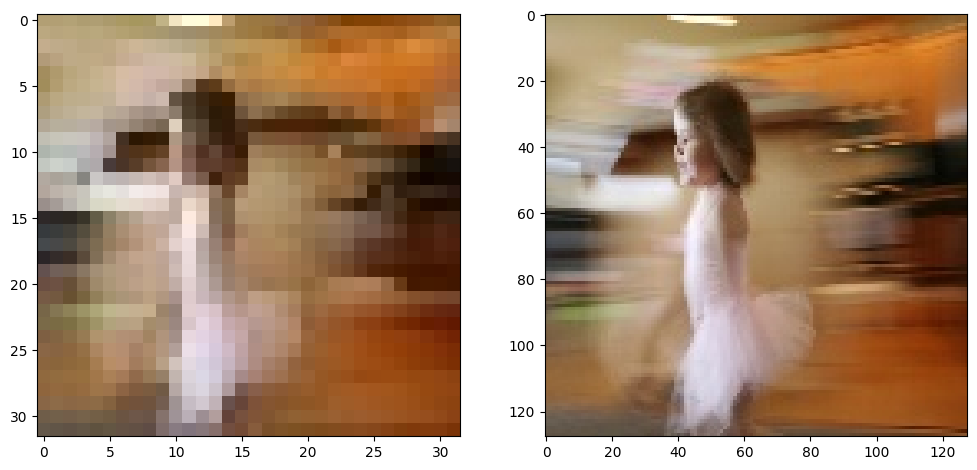

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 32, 32, 64)           15616     ['input_4[0][0]']             
                                                                                                  
 p_re_lu_19 (PReLU)          (None, 32, 32, 64)           64        ['conv2d_45[0][0]']           
                                                                                                  
 conv2d_46 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_19[0][0]']          
                                                                                            

  0%|          | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 88ms/step


  0%|          | 1/3350 [00:27<25:55:48, 27.87s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/3350 [00:28<10:45:40, 11.57s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 3/3350 [00:28<5:54:41,  6.36s/it] 

1/1 [==============================] - 0s 19ms/step


  0%|          | 4/3350 [00:28<3:37:57,  3.91s/it]

1/1 [==============================] - 0s 19ms/step


  0%|          | 5/3350 [00:28<2:22:23,  2.55s/it]

1/1 [==============================] - 0s 19ms/step


  0%|          | 6/3350 [00:28<1:36:55,  1.74s/it]

1/1 [==============================] - 0s 19ms/step


  0%|          | 7/3350 [00:28<1:07:59,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


  0%|          | 8/3350 [00:28<49:02,  1.14it/s]  

1/1 [==============================] - 0s 19ms/step


  0%|          | 9/3350 [00:29<36:23,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 10/3350 [00:29<27:49,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 11/3350 [00:29<21:54,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 12/3350 [00:29<17:51,  3.11it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 13/3350 [00:29<14:59,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 14/3350 [00:29<13:02,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 15/3350 [00:30<11:43,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 16/3350 [00:30<10:47,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 17/3350 [00:30<10:10,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 18/3350 [00:30<09:38,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 19/3350 [00:30<09:19,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 20/3350 [00:30<09:12,  6.02it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 21/3350 [00:31<09:44,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 22/3350 [00:31<09:44,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 23/3350 [00:31<09:22,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 24/3350 [00:31<09:17,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 25/3350 [00:31<09:18,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 26/3350 [00:31<09:28,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 27/3350 [00:32<09:19,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 28/3350 [00:32<09:08,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 29/3350 [00:32<09:03,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 30/3350 [00:32<08:55,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 31/3350 [00:32<08:44,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 32/3350 [00:32<08:38,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 33/3350 [00:32<08:37,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 34/3350 [00:33<08:34,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 35/3350 [00:33<08:35,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 36/3350 [00:33<08:33,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 37/3350 [00:33<08:30,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 38/3350 [00:33<08:28,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 39/3350 [00:33<08:27,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 40/3350 [00:34<08:25,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 41/3350 [00:34<08:27,  6.52it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 42/3350 [00:34<08:33,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 43/3350 [00:34<08:30,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 44/3350 [00:34<08:33,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 45/3350 [00:34<08:34,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 46/3350 [00:34<08:32,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 47/3350 [00:35<08:29,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 48/3350 [00:35<08:30,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 49/3350 [00:35<08:29,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 50/3350 [00:35<08:27,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 51/3350 [00:35<08:32,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 52/3350 [00:35<08:35,  6.40it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 53/3350 [00:36<08:42,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 54/3350 [00:36<08:39,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 55/3350 [00:36<08:47,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 56/3350 [00:36<08:41,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 57/3350 [00:36<08:34,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 58/3350 [00:36<08:29,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 59/3350 [00:36<08:25,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 60/3350 [00:37<08:29,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 61/3350 [00:37<08:34,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 62/3350 [00:37<08:35,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 63/3350 [00:37<08:32,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 64/3350 [00:37<08:30,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 65/3350 [00:37<08:29,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 66/3350 [00:38<08:27,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 67/3350 [00:38<08:26,  6.48it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 68/3350 [00:38<08:43,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 69/3350 [00:38<08:38,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 70/3350 [00:38<08:34,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 71/3350 [00:38<08:30,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 72/3350 [00:39<08:29,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 73/3350 [00:39<08:24,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 74/3350 [00:39<08:31,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 75/3350 [00:39<08:26,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 76/3350 [00:39<08:25,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 77/3350 [00:39<08:30,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 78/3350 [00:39<08:31,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 79/3350 [00:40<08:26,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 80/3350 [00:40<08:27,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 81/3350 [00:40<08:35,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 82/3350 [00:40<08:30,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 83/3350 [00:40<08:26,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 84/3350 [00:40<08:23,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 85/3350 [00:41<08:26,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 86/3350 [00:41<08:32,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 87/3350 [00:41<08:30,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 88/3350 [00:41<08:54,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 89/3350 [00:41<08:41,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 90/3350 [00:41<08:34,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 91/3350 [00:41<08:30,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 92/3350 [00:42<08:29,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 93/3350 [00:42<08:26,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 94/3350 [00:42<08:46,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 95/3350 [00:42<08:47,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 96/3350 [00:42<08:40,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 97/3350 [00:42<08:38,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 98/3350 [00:43<08:34,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 99/3350 [00:43<08:35,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 100/3350 [00:43<08:34,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 101/3350 [00:43<08:31,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 102/3350 [00:43<08:30,  6.36it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 103/3350 [00:43<08:35,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 104/3350 [00:44<08:43,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 105/3350 [00:44<08:36,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 106/3350 [00:44<08:32,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 107/3350 [00:44<08:29,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 108/3350 [00:44<08:29,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 109/3350 [00:44<08:25,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 110/3350 [00:44<08:22,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 111/3350 [00:45<08:19,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 112/3350 [00:45<08:25,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 113/3350 [00:45<08:29,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 114/3350 [00:45<08:27,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 115/3350 [00:45<08:24,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 116/3350 [00:45<08:27,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 117/3350 [00:46<08:28,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 118/3350 [00:46<08:28,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 119/3350 [00:46<08:28,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 120/3350 [00:46<08:28,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 121/3350 [00:46<08:30,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 122/3350 [00:46<08:24,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 123/3350 [00:47<08:21,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 124/3350 [00:47<08:21,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 125/3350 [00:47<08:22,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 126/3350 [00:47<08:20,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 127/3350 [00:47<08:22,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 128/3350 [00:47<08:21,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 129/3350 [00:47<08:21,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 130/3350 [00:48<08:30,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 131/3350 [00:48<08:28,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 132/3350 [00:48<08:28,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 133/3350 [00:48<08:25,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 134/3350 [00:48<08:21,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 135/3350 [00:48<08:17,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 136/3350 [00:49<08:15,  6.49it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 137/3350 [00:49<08:14,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 138/3350 [00:49<08:16,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 139/3350 [00:49<08:21,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 140/3350 [00:49<08:20,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 141/3350 [00:49<08:16,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 142/3350 [00:49<08:18,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 143/3350 [00:50<08:16,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 144/3350 [00:50<08:15,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 145/3350 [00:50<08:13,  6.49it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 146/3350 [00:50<08:12,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 147/3350 [00:50<08:11,  6.52it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 148/3350 [00:50<08:18,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 149/3350 [00:51<08:16,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 150/3350 [00:51<08:20,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 151/3350 [00:51<08:22,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 152/3350 [00:51<08:17,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 153/3350 [00:51<08:17,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 154/3350 [00:51<08:14,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 155/3350 [00:51<08:11,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 156/3350 [00:52<08:17,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 157/3350 [00:52<08:18,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 158/3350 [00:52<08:16,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 159/3350 [00:52<08:15,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 160/3350 [00:52<08:11,  6.49it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 161/3350 [00:52<08:08,  6.52it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 162/3350 [00:53<08:09,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 163/3350 [00:53<08:09,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 164/3350 [00:53<08:09,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 165/3350 [00:53<08:14,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 166/3350 [00:53<08:17,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 167/3350 [00:53<08:14,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 168/3350 [00:54<08:14,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 169/3350 [00:54<08:22,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 170/3350 [00:54<08:31,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 171/3350 [00:54<08:25,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 172/3350 [00:54<08:18,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 173/3350 [00:54<08:17,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 174/3350 [00:54<08:22,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 175/3350 [00:55<08:32,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 176/3350 [00:55<08:40,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 177/3350 [00:55<08:35,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 178/3350 [00:55<08:33,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 179/3350 [00:55<08:23,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 180/3350 [00:55<08:18,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 181/3350 [00:56<08:16,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 182/3350 [00:56<08:13,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 183/3350 [00:56<08:18,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 184/3350 [00:56<08:15,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 185/3350 [00:56<08:18,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 186/3350 [00:56<08:14,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 187/3350 [00:57<08:10,  6.45it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 188/3350 [00:57<08:10,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 189/3350 [00:57<08:11,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 190/3350 [00:57<08:11,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 191/3350 [00:57<08:07,  6.48it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 192/3350 [00:57<08:08,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 193/3350 [00:57<08:07,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 194/3350 [00:58<08:08,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 195/3350 [00:58<08:33,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 196/3350 [00:58<08:27,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 197/3350 [00:58<08:24,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 198/3350 [00:58<08:19,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 199/3350 [00:58<08:12,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 200/3350 [00:59<08:16,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 201/3350 [00:59<08:16,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 202/3350 [00:59<08:19,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 203/3350 [00:59<08:15,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 204/3350 [00:59<08:12,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 205/3350 [00:59<08:10,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 206/3350 [01:00<08:10,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 207/3350 [01:00<08:11,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 208/3350 [01:00<08:15,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 209/3350 [01:00<08:18,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 210/3350 [01:00<08:13,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 211/3350 [01:00<08:10,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 212/3350 [01:00<08:08,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 213/3350 [01:01<08:07,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 214/3350 [01:01<08:08,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 215/3350 [01:01<08:09,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 216/3350 [01:01<08:03,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 217/3350 [01:01<08:00,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 218/3350 [01:01<08:08,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 219/3350 [01:02<08:07,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 220/3350 [01:02<08:07,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 221/3350 [01:02<08:08,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 222/3350 [01:02<08:04,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 223/3350 [01:02<08:05,  6.44it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 224/3350 [01:02<08:06,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 225/3350 [01:02<08:03,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 226/3350 [01:03<08:03,  6.46it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 227/3350 [01:03<08:19,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 228/3350 [01:03<08:14,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 229/3350 [01:03<08:09,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 230/3350 [01:03<08:05,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 231/3350 [01:03<08:03,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 232/3350 [01:04<08:02,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 233/3350 [01:04<08:01,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 234/3350 [01:04<08:05,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 235/3350 [01:04<08:04,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 236/3350 [01:04<08:07,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 237/3350 [01:04<08:02,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 238/3350 [01:05<08:08,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 239/3350 [01:05<08:04,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 240/3350 [01:05<08:04,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 241/3350 [01:05<08:06,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 242/3350 [01:05<08:05,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 243/3350 [01:05<08:06,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 244/3350 [01:05<08:22,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 245/3350 [01:06<08:29,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 246/3350 [01:06<08:21,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 247/3350 [01:06<08:19,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 248/3350 [01:06<08:23,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 249/3350 [01:06<08:24,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 250/3350 [01:06<08:24,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 251/3350 [01:07<08:23,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 252/3350 [01:07<08:21,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 253/3350 [01:07<08:22,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 254/3350 [01:07<08:15,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 255/3350 [01:07<08:08,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 256/3350 [01:07<08:10,  6.31it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 257/3350 [01:08<08:16,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 258/3350 [01:08<08:11,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 259/3350 [01:08<08:08,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 260/3350 [01:08<08:07,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 261/3350 [01:08<08:04,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 262/3350 [01:08<08:07,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 263/3350 [01:08<08:05,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 264/3350 [01:09<08:11,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 265/3350 [01:09<08:07,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 266/3350 [01:09<08:07,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 267/3350 [01:09<08:03,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 268/3350 [01:09<07:59,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 269/3350 [01:09<07:56,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 270/3350 [01:10<07:59,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 271/3350 [01:10<08:04,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 272/3350 [01:10<08:02,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 273/3350 [01:10<08:01,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 274/3350 [01:10<08:01,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 275/3350 [01:10<08:04,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 276/3350 [01:11<08:04,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 277/3350 [01:11<08:05,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 278/3350 [01:11<08:02,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 279/3350 [01:11<08:00,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 280/3350 [01:11<08:04,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 281/3350 [01:11<08:03,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 282/3350 [01:11<08:03,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 283/3350 [01:12<08:02,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 284/3350 [01:12<08:03,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 285/3350 [01:12<08:02,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 286/3350 [01:12<07:57,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 287/3350 [01:12<07:54,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 288/3350 [01:12<07:51,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 289/3350 [01:13<07:54,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 290/3350 [01:13<08:01,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 291/3350 [01:13<07:55,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 292/3350 [01:13<07:52,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 293/3350 [01:13<07:53,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 294/3350 [01:13<07:53,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 295/3350 [01:13<07:53,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 296/3350 [01:14<07:51,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 297/3350 [01:14<07:52,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 298/3350 [01:14<07:57,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 299/3350 [01:14<08:03,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 300/3350 [01:14<07:58,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 301/3350 [01:14<07:56,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 302/3350 [01:15<07:54,  6.42it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 303/3350 [01:15<07:56,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 304/3350 [01:15<07:54,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 305/3350 [01:15<07:51,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 306/3350 [01:15<07:47,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 307/3350 [01:15<07:48,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 308/3350 [01:16<07:50,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 309/3350 [01:16<07:55,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 310/3350 [01:16<07:56,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 311/3350 [01:16<07:54,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 312/3350 [01:16<07:51,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 313/3350 [01:16<07:48,  6.49it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 314/3350 [01:16<07:45,  6.53it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 315/3350 [01:17<07:52,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 316/3350 [01:17<07:54,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 317/3350 [01:17<08:00,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 318/3350 [01:17<07:58,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 319/3350 [01:17<08:05,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 320/3350 [01:17<08:01,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 321/3350 [01:18<07:57,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 322/3350 [01:18<07:54,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 323/3350 [01:18<08:06,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 324/3350 [01:18<08:07,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 325/3350 [01:18<08:06,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 326/3350 [01:18<08:03,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 327/3350 [01:19<08:00,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 328/3350 [01:19<07:53,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 329/3350 [01:19<07:51,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 330/3350 [01:19<07:52,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 331/3350 [01:19<07:52,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 332/3350 [01:19<07:48,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 333/3350 [01:19<07:51,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 334/3350 [01:20<07:48,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 335/3350 [01:20<07:46,  6.46it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 336/3350 [01:20<07:52,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 337/3350 [01:20<07:52,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 338/3350 [01:20<07:50,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 339/3350 [01:20<07:47,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 340/3350 [01:21<07:44,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 341/3350 [01:21<07:43,  6.49it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 342/3350 [01:21<07:52,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 343/3350 [01:21<07:53,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 344/3350 [01:21<07:51,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 345/3350 [01:21<07:49,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 346/3350 [01:21<07:45,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 347/3350 [01:22<07:48,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 348/3350 [01:22<07:46,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 349/3350 [01:22<07:46,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 350/3350 [01:22<07:47,  6.42it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 351/3350 [01:22<07:54,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 352/3350 [01:22<07:49,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 353/3350 [01:23<07:48,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 354/3350 [01:23<07:52,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 355/3350 [01:23<07:53,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 356/3350 [01:23<07:49,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 357/3350 [01:23<07:46,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 358/3350 [01:23<07:45,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 359/3350 [01:24<07:52,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 360/3350 [01:24<07:53,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 361/3350 [01:24<07:58,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 362/3350 [01:24<07:57,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 363/3350 [01:24<07:51,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 364/3350 [01:24<07:48,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 365/3350 [01:24<07:45,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 366/3350 [01:25<07:42,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 367/3350 [01:25<07:41,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 368/3350 [01:25<07:48,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 369/3350 [01:25<07:45,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 370/3350 [01:25<07:44,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 371/3350 [01:25<07:41,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 372/3350 [01:26<07:42,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 373/3350 [01:26<07:44,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 374/3350 [01:26<07:45,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 375/3350 [01:26<07:40,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 376/3350 [01:26<07:38,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 377/3350 [01:26<07:44,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 378/3350 [01:26<07:41,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 379/3350 [01:27<07:43,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 380/3350 [01:27<07:41,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 381/3350 [01:27<07:40,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 382/3350 [01:27<07:38,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 383/3350 [01:27<07:38,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 384/3350 [01:27<07:38,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 385/3350 [01:28<07:40,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 386/3350 [01:28<08:10,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 387/3350 [01:28<08:03,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 388/3350 [01:28<07:59,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 389/3350 [01:28<07:53,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 390/3350 [01:28<07:50,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 391/3350 [01:29<07:52,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 392/3350 [01:29<07:55,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 393/3350 [01:29<07:54,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 394/3350 [01:29<07:49,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 395/3350 [01:29<07:57,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 396/3350 [01:29<08:02,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 397/3350 [01:30<07:57,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 398/3350 [01:30<07:54,  6.22it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 399/3350 [01:30<07:52,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 400/3350 [01:30<07:52,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 401/3350 [01:30<07:51,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 402/3350 [01:30<07:49,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 403/3350 [01:30<07:51,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 404/3350 [01:31<07:44,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 405/3350 [01:31<07:42,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 406/3350 [01:31<07:39,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 407/3350 [01:31<07:41,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 408/3350 [01:31<07:43,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 409/3350 [01:31<07:37,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 410/3350 [01:32<07:35,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 411/3350 [01:32<07:31,  6.52it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 412/3350 [01:32<07:38,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 413/3350 [01:32<07:35,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 414/3350 [01:32<07:42,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 415/3350 [01:32<07:38,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 416/3350 [01:33<07:48,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 417/3350 [01:33<07:44,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 418/3350 [01:33<07:41,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 419/3350 [01:33<07:40,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 420/3350 [01:33<07:40,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 421/3350 [01:33<07:47,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 422/3350 [01:33<07:42,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 423/3350 [01:34<07:38,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 424/3350 [01:34<07:39,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 425/3350 [01:34<07:42,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 426/3350 [01:34<07:39,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 427/3350 [01:34<07:46,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 428/3350 [01:34<07:42,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 429/3350 [01:35<07:36,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 430/3350 [01:35<07:47,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 431/3350 [01:35<07:44,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 432/3350 [01:35<07:40,  6.34it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 433/3350 [01:35<07:48,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 434/3350 [01:35<07:43,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 435/3350 [01:36<07:44,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 436/3350 [01:36<07:41,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 437/3350 [01:36<07:41,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 438/3350 [01:36<07:36,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 439/3350 [01:36<07:41,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 440/3350 [01:36<07:40,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 441/3350 [01:36<07:37,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 442/3350 [01:37<07:39,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 443/3350 [01:37<07:40,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 444/3350 [01:37<07:37,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 445/3350 [01:37<07:37,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 446/3350 [01:37<07:31,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 447/3350 [01:37<07:37,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 448/3350 [01:38<07:36,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 449/3350 [01:38<07:32,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 450/3350 [01:38<07:30,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 451/3350 [01:38<07:31,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 452/3350 [01:38<07:29,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 453/3350 [01:38<07:27,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 454/3350 [01:38<07:24,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 455/3350 [01:39<07:22,  6.54it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 456/3350 [01:39<07:30,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 457/3350 [01:39<07:30,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 458/3350 [01:39<07:29,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 459/3350 [01:39<07:32,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 460/3350 [01:39<07:28,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 461/3350 [01:40<07:26,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 462/3350 [01:40<07:24,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 463/3350 [01:40<07:27,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 464/3350 [01:40<07:28,  6.44it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 465/3350 [01:40<07:39,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 466/3350 [01:40<07:38,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 467/3350 [01:41<07:41,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 468/3350 [01:41<07:42,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 469/3350 [01:41<07:41,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 470/3350 [01:41<07:41,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 471/3350 [01:41<07:40,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 472/3350 [01:41<07:39,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 473/3350 [01:41<07:37,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 474/3350 [01:42<07:46,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 475/3350 [01:42<07:43,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 476/3350 [01:42<07:35,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 477/3350 [01:42<07:30,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 478/3350 [01:42<07:27,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 479/3350 [01:42<07:25,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 480/3350 [01:43<07:24,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 481/3350 [01:43<07:25,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 482/3350 [01:43<07:23,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 483/3350 [01:43<07:30,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 484/3350 [01:43<07:30,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 485/3350 [01:43<07:26,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 486/3350 [01:44<07:25,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 487/3350 [01:44<07:23,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 488/3350 [01:44<07:25,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 489/3350 [01:44<07:21,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 490/3350 [01:44<07:19,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 491/3350 [01:44<07:25,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 492/3350 [01:44<07:27,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 493/3350 [01:45<07:25,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 494/3350 [01:45<07:24,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 495/3350 [01:45<07:25,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 496/3350 [01:45<07:23,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 497/3350 [01:45<07:24,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 498/3350 [01:45<07:24,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 499/3350 [01:46<07:30,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 500/3350 [01:46<07:45,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 501/3350 [01:46<07:43,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 502/3350 [01:46<07:39,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 503/3350 [01:46<07:34,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 504/3350 [01:46<07:32,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 505/3350 [01:47<07:28,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 506/3350 [01:47<07:26,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 507/3350 [01:47<07:29,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 508/3350 [01:47<07:24,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 509/3350 [01:47<07:29,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 510/3350 [01:47<07:28,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 511/3350 [01:47<07:30,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 512/3350 [01:48<07:29,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 513/3350 [01:48<07:29,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 514/3350 [01:48<07:25,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 515/3350 [01:48<07:20,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 516/3350 [01:48<07:17,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 517/3350 [01:48<07:17,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 518/3350 [01:49<07:22,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 519/3350 [01:49<07:20,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 520/3350 [01:49<07:18,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 521/3350 [01:49<07:19,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 522/3350 [01:49<07:18,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 523/3350 [01:49<07:18,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 524/3350 [01:49<07:14,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 525/3350 [01:50<07:14,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 526/3350 [01:50<07:13,  6.52it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 527/3350 [01:50<07:19,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 528/3350 [01:50<07:18,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 529/3350 [01:50<07:19,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 530/3350 [01:50<07:19,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 531/3350 [01:51<07:18,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 532/3350 [01:51<07:18,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 533/3350 [01:51<07:17,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 534/3350 [01:51<07:13,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 535/3350 [01:51<07:16,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 536/3350 [01:51<07:14,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 537/3350 [01:51<07:18,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 538/3350 [01:52<07:22,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 539/3350 [01:52<07:31,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 540/3350 [01:52<07:28,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 541/3350 [01:52<07:30,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 542/3350 [01:52<07:28,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 543/3350 [01:52<07:24,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 544/3350 [01:53<07:31,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 545/3350 [01:53<07:31,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 546/3350 [01:53<07:30,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 547/3350 [01:53<07:27,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 548/3350 [01:53<07:28,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 549/3350 [01:53<07:24,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 550/3350 [01:54<07:20,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 551/3350 [01:54<07:16,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 552/3350 [01:54<07:14,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 553/3350 [01:54<07:21,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 554/3350 [01:54<07:20,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 555/3350 [01:54<07:16,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 556/3350 [01:54<07:13,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 557/3350 [01:55<07:15,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 558/3350 [01:55<07:15,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 559/3350 [01:55<07:17,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 560/3350 [01:55<07:12,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 561/3350 [01:55<07:08,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 562/3350 [01:55<07:13,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 563/3350 [01:56<07:14,  6.42it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 564/3350 [01:56<07:23,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 565/3350 [01:56<07:21,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 566/3350 [01:56<07:15,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 567/3350 [01:56<07:14,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 568/3350 [01:56<07:10,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 569/3350 [01:57<07:09,  6.48it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 570/3350 [01:57<07:26,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 571/3350 [01:57<07:25,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 572/3350 [01:57<07:19,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 573/3350 [01:57<07:17,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 574/3350 [01:57<07:13,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 575/3350 [01:57<07:11,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 576/3350 [01:58<07:09,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 577/3350 [01:58<07:14,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 578/3350 [01:58<07:17,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 579/3350 [01:58<07:20,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 580/3350 [01:58<07:19,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 581/3350 [01:58<07:16,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 582/3350 [01:59<07:15,  6.36it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 583/3350 [01:59<07:21,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 584/3350 [01:59<07:21,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 585/3350 [01:59<07:18,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 586/3350 [01:59<07:12,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 587/3350 [01:59<07:11,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 588/3350 [02:00<07:18,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 589/3350 [02:00<07:17,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 590/3350 [02:00<07:26,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 591/3350 [02:00<07:18,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 592/3350 [02:00<07:18,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 593/3350 [02:00<07:13,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 594/3350 [02:00<07:15,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 595/3350 [02:01<07:11,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 596/3350 [02:01<07:17,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 597/3350 [02:01<07:18,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 598/3350 [02:01<07:13,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 599/3350 [02:01<07:15,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 600/3350 [02:01<07:12,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 601/3350 [02:02<07:10,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 602/3350 [02:02<07:08,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 603/3350 [02:02<07:06,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 604/3350 [02:02<07:06,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 605/3350 [02:02<07:10,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 606/3350 [02:02<07:19,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 607/3350 [02:03<07:19,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 608/3350 [02:03<07:16,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 609/3350 [02:03<07:19,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 610/3350 [02:03<07:26,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 611/3350 [02:03<07:22,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 612/3350 [02:03<07:24,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 613/3350 [02:04<07:34,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 614/3350 [02:04<07:53,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 615/3350 [02:04<07:57,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 616/3350 [02:04<07:48,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 617/3350 [02:04<07:43,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 618/3350 [02:04<07:38,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 619/3350 [02:05<07:36,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 620/3350 [02:05<07:34,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 621/3350 [02:05<07:30,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 622/3350 [02:05<07:24,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 623/3350 [02:05<07:23,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 624/3350 [02:05<07:17,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 625/3350 [02:06<07:15,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 626/3350 [02:06<07:09,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 627/3350 [02:06<07:07,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 628/3350 [02:06<07:30,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 629/3350 [02:06<07:21,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 630/3350 [02:06<07:14,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 631/3350 [02:06<07:07,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 632/3350 [02:07<07:10,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 633/3350 [02:07<07:09,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 634/3350 [02:07<07:09,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 635/3350 [02:07<07:05,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 636/3350 [02:07<07:04,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 637/3350 [02:07<07:04,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 638/3350 [02:08<07:03,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 639/3350 [02:08<07:01,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 640/3350 [02:08<07:03,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 641/3350 [02:08<07:11,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 642/3350 [02:08<07:06,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 643/3350 [02:08<07:02,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 644/3350 [02:09<07:10,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 645/3350 [02:09<07:05,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 646/3350 [02:09<07:05,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 647/3350 [02:09<07:06,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 648/3350 [02:09<07:03,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 649/3350 [02:09<06:59,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 650/3350 [02:09<07:09,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 651/3350 [02:10<07:06,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 652/3350 [02:10<07:08,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 653/3350 [02:10<07:11,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 654/3350 [02:10<07:11,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 655/3350 [02:10<07:07,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 656/3350 [02:10<07:09,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 657/3350 [02:11<07:08,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 658/3350 [02:11<07:05,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 659/3350 [02:11<07:10,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 660/3350 [02:11<07:08,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 661/3350 [02:11<07:06,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 662/3350 [02:11<07:05,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 663/3350 [02:12<07:04,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 664/3350 [02:12<07:04,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 665/3350 [02:12<07:05,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 666/3350 [02:12<07:01,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 667/3350 [02:12<07:01,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 668/3350 [02:12<07:04,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 669/3350 [02:12<07:00,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 670/3350 [02:13<06:59,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 671/3350 [02:13<07:02,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 672/3350 [02:13<07:02,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 673/3350 [02:13<07:01,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 674/3350 [02:13<07:00,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 675/3350 [02:13<06:55,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 676/3350 [02:14<07:00,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 677/3350 [02:14<07:03,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 678/3350 [02:14<07:03,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 679/3350 [02:14<07:00,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 680/3350 [02:14<07:00,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 681/3350 [02:14<06:56,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 682/3350 [02:15<06:56,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 683/3350 [02:15<06:56,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 684/3350 [02:15<06:58,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 685/3350 [02:15<07:03,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 686/3350 [02:15<07:06,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 687/3350 [02:15<07:05,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 688/3350 [02:15<07:04,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 689/3350 [02:16<07:05,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 690/3350 [02:16<07:04,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 691/3350 [02:16<07:10,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 692/3350 [02:16<07:19,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 693/3350 [02:16<07:16,  6.09it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 694/3350 [02:16<07:24,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 695/3350 [02:17<07:21,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 696/3350 [02:17<07:19,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 697/3350 [02:17<07:13,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 698/3350 [02:17<07:09,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 699/3350 [02:17<07:04,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 700/3350 [02:17<06:58,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 701/3350 [02:18<07:01,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 702/3350 [02:18<06:58,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 703/3350 [02:18<07:03,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 704/3350 [02:18<07:00,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 705/3350 [02:18<06:56,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 706/3350 [02:18<06:54,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 707/3350 [02:19<06:50,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 708/3350 [02:19<06:49,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 709/3350 [02:19<06:49,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 710/3350 [02:19<06:49,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 711/3350 [02:19<06:52,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 712/3350 [02:19<07:00,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 713/3350 [02:19<06:57,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 714/3350 [02:20<06:55,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 715/3350 [02:20<06:54,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 716/3350 [02:20<06:55,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 717/3350 [02:20<06:51,  6.40it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 718/3350 [02:20<06:56,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 719/3350 [02:20<06:55,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 720/3350 [02:21<06:55,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 721/3350 [02:21<07:02,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 722/3350 [02:21<07:00,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 723/3350 [02:21<06:55,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 724/3350 [02:21<06:54,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 725/3350 [02:21<07:00,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 726/3350 [02:22<06:57,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 727/3350 [02:22<06:54,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 728/3350 [02:22<06:53,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 729/3350 [02:22<06:56,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 730/3350 [02:22<06:58,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 731/3350 [02:22<06:58,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 732/3350 [02:22<07:03,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 733/3350 [02:23<07:02,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 734/3350 [02:23<07:02,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 735/3350 [02:23<06:59,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 736/3350 [02:23<06:56,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 737/3350 [02:23<07:11,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 738/3350 [02:23<07:11,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 739/3350 [02:24<07:08,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 740/3350 [02:24<07:07,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 741/3350 [02:24<07:05,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 742/3350 [02:24<06:58,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 743/3350 [02:24<06:58,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 744/3350 [02:24<07:01,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 745/3350 [02:25<06:53,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 746/3350 [02:25<06:52,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 747/3350 [02:25<06:56,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 748/3350 [02:25<06:53,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 749/3350 [02:25<06:49,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 750/3350 [02:25<06:49,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 751/3350 [02:26<06:50,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 752/3350 [02:26<06:47,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 753/3350 [02:26<06:47,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 754/3350 [02:26<06:44,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 755/3350 [02:26<06:39,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 756/3350 [02:26<06:48,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 757/3350 [02:26<06:47,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 758/3350 [02:27<06:45,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 759/3350 [02:27<06:48,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 760/3350 [02:27<06:48,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 761/3350 [02:27<06:45,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 762/3350 [02:27<06:47,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 763/3350 [02:27<06:52,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 764/3350 [02:28<06:54,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 765/3350 [02:28<07:03,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 766/3350 [02:28<07:04,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 767/3350 [02:28<07:03,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 768/3350 [02:28<06:57,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 769/3350 [02:28<06:54,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 770/3350 [02:29<06:48,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 771/3350 [02:29<06:49,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 772/3350 [02:29<06:47,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 773/3350 [02:29<06:51,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 774/3350 [02:29<06:48,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 775/3350 [02:29<07:07,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 776/3350 [02:30<07:06,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 777/3350 [02:30<06:59,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 778/3350 [02:30<06:51,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 779/3350 [02:30<06:47,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 780/3350 [02:30<06:45,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 781/3350 [02:30<06:40,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 782/3350 [02:30<06:47,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 783/3350 [02:31<06:45,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 784/3350 [02:31<06:45,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 785/3350 [02:31<06:45,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 786/3350 [02:31<06:41,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 787/3350 [02:31<06:42,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 788/3350 [02:31<06:38,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 789/3350 [02:32<06:39,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 790/3350 [02:32<06:48,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 791/3350 [02:32<06:50,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 792/3350 [02:32<06:44,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 793/3350 [02:32<06:42,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 794/3350 [02:32<06:37,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 795/3350 [02:33<06:37,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 796/3350 [02:33<06:37,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 797/3350 [02:33<06:36,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 798/3350 [02:33<06:32,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 799/3350 [02:33<06:33,  6.49it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 800/3350 [02:33<06:39,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 801/3350 [02:33<06:36,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 802/3350 [02:34<06:38,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 803/3350 [02:34<06:39,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 804/3350 [02:34<06:40,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 805/3350 [02:34<06:42,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 806/3350 [02:34<06:41,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 807/3350 [02:34<06:39,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 808/3350 [02:35<06:47,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 809/3350 [02:35<06:49,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 810/3350 [02:35<06:44,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 811/3350 [02:35<06:42,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 812/3350 [02:35<06:39,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 813/3350 [02:35<06:39,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 814/3350 [02:36<06:40,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 815/3350 [02:36<06:44,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 816/3350 [02:36<06:48,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 817/3350 [02:36<06:46,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 818/3350 [02:36<06:40,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 819/3350 [02:36<06:38,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 820/3350 [02:36<06:36,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 821/3350 [02:37<06:33,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 822/3350 [02:37<06:33,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 823/3350 [02:37<06:34,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 824/3350 [02:37<06:34,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 825/3350 [02:37<06:30,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 826/3350 [02:37<06:36,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 827/3350 [02:38<06:35,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 828/3350 [02:38<06:36,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 829/3350 [02:38<06:37,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 830/3350 [02:38<06:35,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 831/3350 [02:38<06:39,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 832/3350 [02:38<06:40,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 833/3350 [02:38<06:38,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 834/3350 [02:39<06:38,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 835/3350 [02:39<06:43,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 836/3350 [02:39<06:41,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 837/3350 [02:39<06:46,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 838/3350 [02:39<06:46,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 839/3350 [02:39<06:42,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 840/3350 [02:40<06:41,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 841/3350 [02:40<06:47,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 842/3350 [02:40<06:41,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 843/3350 [02:40<06:37,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 844/3350 [02:40<06:38,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 845/3350 [02:40<06:35,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 846/3350 [02:41<06:37,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 847/3350 [02:41<06:41,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 848/3350 [02:41<06:38,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 849/3350 [02:41<06:38,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 850/3350 [02:41<06:32,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 851/3350 [02:41<06:29,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 852/3350 [02:42<06:31,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 853/3350 [02:42<06:35,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 854/3350 [02:42<06:36,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 855/3350 [02:42<06:33,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 856/3350 [02:42<06:30,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 857/3350 [02:42<06:27,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 858/3350 [02:42<06:24,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 859/3350 [02:43<06:23,  6.49it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 860/3350 [02:43<06:25,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 861/3350 [02:43<06:28,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 862/3350 [02:43<06:26,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 863/3350 [02:43<06:25,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 864/3350 [02:43<06:24,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 865/3350 [02:44<06:22,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 866/3350 [02:44<06:23,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 867/3350 [02:44<06:25,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 868/3350 [02:44<06:22,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 869/3350 [02:44<06:21,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 870/3350 [02:44<06:30,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 871/3350 [02:44<06:28,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 872/3350 [02:45<06:26,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 873/3350 [02:45<06:29,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 874/3350 [02:45<06:32,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 875/3350 [02:45<06:28,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 876/3350 [02:45<06:29,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 877/3350 [02:45<06:29,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 878/3350 [02:46<06:29,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 879/3350 [02:46<06:29,  6.34it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 880/3350 [02:46<06:38,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 881/3350 [02:46<06:34,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 882/3350 [02:46<06:34,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 883/3350 [02:46<06:34,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 884/3350 [02:47<06:32,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 885/3350 [02:47<06:29,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 886/3350 [02:47<06:37,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 887/3350 [02:47<06:30,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 888/3350 [02:47<06:33,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 889/3350 [02:47<06:31,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 890/3350 [02:47<06:31,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 891/3350 [02:48<06:30,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 892/3350 [02:48<06:29,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 893/3350 [02:48<06:28,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 894/3350 [02:48<06:23,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 895/3350 [02:48<06:19,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 896/3350 [02:48<06:24,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 897/3350 [02:49<06:22,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 898/3350 [02:49<06:21,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 899/3350 [02:49<06:30,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 900/3350 [02:49<06:26,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 901/3350 [02:49<06:21,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 902/3350 [02:49<06:18,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 903/3350 [02:50<06:17,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 904/3350 [02:50<06:19,  6.44it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 905/3350 [02:50<06:26,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 906/3350 [02:50<06:39,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 907/3350 [02:50<06:33,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 908/3350 [02:50<06:29,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 909/3350 [02:50<06:36,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 910/3350 [02:51<06:35,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 911/3350 [02:51<06:36,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 912/3350 [02:51<06:38,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 913/3350 [02:51<06:41,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 914/3350 [02:51<06:46,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 915/3350 [02:51<06:45,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 916/3350 [02:52<06:37,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 917/3350 [02:52<06:31,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 918/3350 [02:52<06:26,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 919/3350 [02:52<06:23,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 920/3350 [02:52<06:20,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 921/3350 [02:52<06:15,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 922/3350 [02:53<06:14,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 923/3350 [02:53<06:21,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 924/3350 [02:53<06:21,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 925/3350 [02:53<06:20,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 926/3350 [02:53<06:18,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 927/3350 [02:53<06:18,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 928/3350 [02:54<06:22,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 929/3350 [02:54<06:23,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 930/3350 [02:54<06:24,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 931/3350 [02:54<06:28,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 932/3350 [02:54<06:23,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 933/3350 [02:54<06:20,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 934/3350 [02:54<06:16,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 935/3350 [02:55<06:14,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 936/3350 [02:55<06:14,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 937/3350 [02:55<06:15,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 938/3350 [02:55<06:15,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 939/3350 [02:55<06:13,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 940/3350 [02:55<06:19,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 941/3350 [02:56<06:20,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 942/3350 [02:56<06:19,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 943/3350 [02:56<06:21,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 944/3350 [02:56<06:18,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 945/3350 [02:56<06:17,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 946/3350 [02:56<06:13,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 947/3350 [02:56<06:12,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 948/3350 [02:57<06:10,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 949/3350 [02:57<06:17,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 950/3350 [02:57<06:17,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 951/3350 [02:57<06:15,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 952/3350 [02:57<06:11,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 953/3350 [02:57<06:10,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 954/3350 [02:58<06:15,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 955/3350 [02:58<06:14,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 956/3350 [02:58<06:15,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 957/3350 [02:58<06:14,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 958/3350 [02:58<06:22,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 959/3350 [02:58<06:19,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 960/3350 [02:59<06:17,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 961/3350 [02:59<06:16,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 962/3350 [02:59<06:15,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 963/3350 [02:59<06:13,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 964/3350 [02:59<06:17,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 965/3350 [02:59<06:15,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 966/3350 [02:59<06:15,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 967/3350 [03:00<06:19,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 968/3350 [03:00<06:17,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 969/3350 [03:00<06:16,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 970/3350 [03:00<06:14,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 971/3350 [03:00<06:11,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 972/3350 [03:00<06:11,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 973/3350 [03:01<06:10,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 974/3350 [03:01<06:09,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 975/3350 [03:01<06:08,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 976/3350 [03:01<06:12,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 977/3350 [03:01<06:13,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 978/3350 [03:01<06:09,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 979/3350 [03:02<06:10,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 980/3350 [03:02<06:14,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 981/3350 [03:02<06:13,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 982/3350 [03:02<06:11,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 983/3350 [03:02<06:10,  6.40it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 984/3350 [03:02<06:19,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 985/3350 [03:02<06:19,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 986/3350 [03:03<06:21,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 987/3350 [03:03<06:18,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 988/3350 [03:03<06:25,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 989/3350 [03:03<06:20,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 990/3350 [03:03<06:13,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 991/3350 [03:03<06:08,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 992/3350 [03:04<06:06,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 993/3350 [03:04<06:07,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 994/3350 [03:04<06:07,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 995/3350 [03:04<06:05,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 996/3350 [03:04<06:06,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 997/3350 [03:04<06:04,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 998/3350 [03:05<06:04,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 999/3350 [03:05<06:02,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 1000/3350 [03:05<06:07,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1001/3350 [03:05<06:05,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 1002/3350 [03:05<06:08,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1003/3350 [03:05<06:05,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1004/3350 [03:05<06:06,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1005/3350 [03:06<06:06,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1006/3350 [03:06<06:04,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1007/3350 [03:06<06:06,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1008/3350 [03:06<06:05,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1009/3350 [03:06<06:04,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1010/3350 [03:06<06:03,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1011/3350 [03:07<06:05,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1012/3350 [03:07<06:09,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1013/3350 [03:07<06:09,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1014/3350 [03:07<06:06,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1015/3350 [03:07<06:06,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1016/3350 [03:07<06:04,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1017/3350 [03:07<06:01,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1018/3350 [03:08<06:02,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1019/3350 [03:08<06:02,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1020/3350 [03:08<11:38,  3.34it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1021/3350 [03:09<10:00,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1022/3350 [03:09<08:51,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1023/3350 [03:09<08:04,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1024/3350 [03:09<07:29,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1025/3350 [03:09<07:03,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1026/3350 [03:09<06:53,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1027/3350 [03:10<06:37,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1028/3350 [03:10<06:38,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1029/3350 [03:10<06:33,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1030/3350 [03:10<06:25,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1031/3350 [03:10<06:23,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1032/3350 [03:10<06:26,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1033/3350 [03:11<06:25,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1034/3350 [03:11<06:19,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1035/3350 [03:11<06:18,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1036/3350 [03:11<06:20,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1037/3350 [03:11<06:19,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1038/3350 [03:11<06:19,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1039/3350 [03:12<06:25,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1040/3350 [03:12<06:22,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1041/3350 [03:12<06:19,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1042/3350 [03:12<06:17,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1043/3350 [03:12<06:12,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1044/3350 [03:12<06:15,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1045/3350 [03:13<06:19,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1046/3350 [03:13<06:15,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1047/3350 [03:13<06:12,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1048/3350 [03:13<06:11,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1049/3350 [03:13<06:12,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1050/3350 [03:13<06:16,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1051/3350 [03:13<06:23,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1052/3350 [03:14<06:18,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1053/3350 [03:14<06:23,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1054/3350 [03:14<06:26,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1055/3350 [03:14<06:23,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1056/3350 [03:14<06:19,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1057/3350 [03:14<06:22,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1058/3350 [03:15<06:21,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1059/3350 [03:15<06:19,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1060/3350 [03:15<06:15,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1061/3350 [03:15<06:17,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1062/3350 [03:15<06:12,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1063/3350 [03:15<06:10,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1064/3350 [03:16<06:16,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1065/3350 [03:16<06:13,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1066/3350 [03:16<06:10,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1067/3350 [03:16<06:06,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1068/3350 [03:16<06:07,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1069/3350 [03:16<06:04,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1070/3350 [03:17<06:12,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1071/3350 [03:17<06:08,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1072/3350 [03:17<06:08,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1073/3350 [03:17<06:07,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1074/3350 [03:17<06:05,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1075/3350 [03:17<06:01,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1076/3350 [03:18<06:01,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1077/3350 [03:18<06:00,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1078/3350 [03:18<06:00,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1079/3350 [03:18<06:04,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1080/3350 [03:18<06:02,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1081/3350 [03:18<06:01,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1082/3350 [03:19<05:59,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1083/3350 [03:19<06:04,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1084/3350 [03:19<06:02,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1085/3350 [03:19<05:59,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1086/3350 [03:19<06:00,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1087/3350 [03:19<05:57,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1088/3350 [03:19<06:03,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1089/3350 [03:20<06:03,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1090/3350 [03:20<06:01,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1091/3350 [03:20<06:02,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1092/3350 [03:20<06:00,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1093/3350 [03:20<05:58,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1094/3350 [03:20<05:57,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1095/3350 [03:21<05:55,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1096/3350 [03:21<05:56,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1097/3350 [03:21<06:02,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1098/3350 [03:21<06:01,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1099/3350 [03:21<05:57,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1100/3350 [03:21<05:56,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1101/3350 [03:22<05:54,  6.34it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1102/3350 [03:22<05:53,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1103/3350 [03:22<05:58,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1104/3350 [03:22<05:57,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1105/3350 [03:22<05:57,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1106/3350 [03:22<06:02,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1107/3350 [03:23<06:02,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1108/3350 [03:23<06:06,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1109/3350 [03:23<06:05,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1110/3350 [03:23<06:03,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1111/3350 [03:23<06:01,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1112/3350 [03:23<05:59,  6.23it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1113/3350 [03:23<05:58,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1114/3350 [03:24<06:05,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1115/3350 [03:24<06:07,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1116/3350 [03:24<06:02,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1117/3350 [03:24<06:01,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1118/3350 [03:24<06:00,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1119/3350 [03:24<05:56,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1120/3350 [03:25<05:58,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1121/3350 [03:25<05:58,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1122/3350 [03:25<06:01,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1123/3350 [03:25<06:08,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 1124/3350 [03:25<06:06,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1125/3350 [03:25<06:04,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1126/3350 [03:26<06:22,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1127/3350 [03:26<06:25,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1128/3350 [03:26<06:22,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1129/3350 [03:26<06:14,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1130/3350 [03:26<06:12,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1131/3350 [03:26<06:05,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1132/3350 [03:27<06:09,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1133/3350 [03:27<06:02,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1134/3350 [03:27<05:58,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1135/3350 [03:27<05:54,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1136/3350 [03:27<05:53,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1137/3350 [03:27<05:51,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1138/3350 [03:28<05:49,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1139/3350 [03:28<05:51,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1140/3350 [03:28<05:51,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1141/3350 [03:28<05:54,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1142/3350 [03:28<05:55,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1143/3350 [03:28<05:53,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1144/3350 [03:29<05:55,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1145/3350 [03:29<05:54,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1146/3350 [03:29<05:53,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1147/3350 [03:29<05:49,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1148/3350 [03:29<05:47,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1149/3350 [03:29<05:51,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1150/3350 [03:29<05:50,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1151/3350 [03:30<05:52,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1152/3350 [03:30<05:51,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1153/3350 [03:30<05:49,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1154/3350 [03:30<05:50,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1155/3350 [03:30<05:53,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1156/3350 [03:30<05:51,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1157/3350 [03:31<05:49,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1158/3350 [03:31<05:55,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1159/3350 [03:31<05:52,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1160/3350 [03:31<05:49,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1161/3350 [03:31<05:46,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1162/3350 [03:31<05:42,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1163/3350 [03:32<05:42,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1164/3350 [03:32<05:43,  6.36it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1165/3350 [03:32<05:51,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1166/3350 [03:32<05:49,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1167/3350 [03:32<05:56,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1168/3350 [03:32<05:50,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1169/3350 [03:33<05:46,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1170/3350 [03:33<05:47,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1171/3350 [03:33<05:49,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1172/3350 [03:33<05:48,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1173/3350 [03:33<05:49,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1174/3350 [03:33<05:47,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1175/3350 [03:33<05:43,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1176/3350 [03:34<05:47,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1177/3350 [03:34<05:53,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1178/3350 [03:34<05:53,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1179/3350 [03:34<05:50,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1180/3350 [03:34<05:47,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1181/3350 [03:34<05:45,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1182/3350 [03:35<05:45,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1183/3350 [03:35<05:49,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1184/3350 [03:35<05:57,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1185/3350 [03:35<05:54,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1186/3350 [03:35<05:51,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1187/3350 [03:35<05:50,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1188/3350 [03:36<05:48,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1189/3350 [03:36<05:47,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1190/3350 [03:36<05:46,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1191/3350 [03:36<05:51,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1192/3350 [03:36<05:45,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1193/3350 [03:36<05:50,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1194/3350 [03:37<05:53,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1195/3350 [03:37<05:50,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1196/3350 [03:37<05:47,  6.19it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1197/3350 [03:37<05:48,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1198/3350 [03:37<05:46,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1199/3350 [03:37<05:45,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1200/3350 [03:38<05:51,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1201/3350 [03:38<05:57,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1202/3350 [03:38<06:03,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1203/3350 [03:38<06:04,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1204/3350 [03:38<05:57,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1205/3350 [03:38<05:49,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1206/3350 [03:39<05:44,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1207/3350 [03:39<05:45,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1208/3350 [03:39<05:45,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1209/3350 [03:39<05:40,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1210/3350 [03:39<05:49,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1211/3350 [03:39<05:44,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1212/3350 [03:39<05:43,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1213/3350 [03:40<05:40,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1214/3350 [03:40<05:42,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1215/3350 [03:40<05:39,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 1216/3350 [03:40<05:41,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1217/3350 [03:40<05:39,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1218/3350 [03:40<05:40,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1219/3350 [03:41<05:43,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1220/3350 [03:41<05:45,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1221/3350 [03:41<05:43,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1222/3350 [03:41<05:40,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1223/3350 [03:41<05:38,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1224/3350 [03:41<05:35,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1225/3350 [03:42<05:37,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1226/3350 [03:42<05:34,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1227/3350 [03:42<05:34,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1228/3350 [03:42<05:38,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1229/3350 [03:42<05:35,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1230/3350 [03:42<05:34,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1231/3350 [03:43<05:35,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1232/3350 [03:43<05:36,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1233/3350 [03:43<05:38,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1234/3350 [03:43<05:36,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1235/3350 [03:43<05:38,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1236/3350 [03:43<05:36,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1237/3350 [03:43<05:39,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1238/3350 [03:44<05:35,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1239/3350 [03:44<05:40,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1240/3350 [03:44<05:39,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1241/3350 [03:44<05:35,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1242/3350 [03:44<05:35,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1243/3350 [03:44<05:31,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1244/3350 [03:45<05:30,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1245/3350 [03:45<05:37,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1246/3350 [03:45<05:34,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1247/3350 [03:45<05:37,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1248/3350 [03:45<05:36,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1249/3350 [03:45<05:32,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1250/3350 [03:46<05:34,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1251/3350 [03:46<05:34,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1252/3350 [03:46<05:35,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1253/3350 [03:46<05:37,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1254/3350 [03:46<05:38,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1255/3350 [03:46<05:37,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1256/3350 [03:47<05:37,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1257/3350 [03:47<05:34,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1258/3350 [03:47<05:33,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1259/3350 [03:47<05:35,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1260/3350 [03:47<05:34,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1261/3350 [03:47<05:37,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1262/3350 [03:47<05:35,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1263/3350 [03:48<05:38,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1264/3350 [03:48<05:40,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1265/3350 [03:48<05:37,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1266/3350 [03:48<05:35,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1267/3350 [03:48<05:38,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1268/3350 [03:48<05:36,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1269/3350 [03:49<05:33,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1270/3350 [03:49<05:35,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1271/3350 [03:49<05:37,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1272/3350 [03:49<05:47,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1273/3350 [03:49<05:45,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1274/3350 [03:49<05:41,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1275/3350 [03:50<05:43,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1276/3350 [03:50<05:46,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1277/3350 [03:50<05:39,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1278/3350 [03:50<05:32,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1279/3350 [03:50<05:28,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1280/3350 [03:50<05:29,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1281/3350 [03:51<05:31,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1282/3350 [03:51<05:32,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1283/3350 [03:51<05:36,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1284/3350 [03:51<05:32,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1285/3350 [03:51<05:30,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1286/3350 [03:51<05:27,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1287/3350 [03:52<05:26,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1288/3350 [03:52<05:24,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1289/3350 [03:52<05:30,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1290/3350 [03:52<05:26,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1291/3350 [03:52<05:24,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1292/3350 [03:52<05:22,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1293/3350 [03:52<05:22,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1294/3350 [03:53<05:20,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1295/3350 [03:53<05:21,  6.40it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1296/3350 [03:53<05:20,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1297/3350 [03:53<05:20,  6.40it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1298/3350 [03:53<05:24,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1299/3350 [03:53<05:23,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1300/3350 [03:54<05:23,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1301/3350 [03:54<05:22,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1302/3350 [03:54<05:26,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1303/3350 [03:54<05:26,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1304/3350 [03:54<05:24,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1305/3350 [03:54<05:21,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1306/3350 [03:55<05:20,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1307/3350 [03:55<05:26,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1308/3350 [03:55<05:26,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1309/3350 [03:55<05:24,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1310/3350 [03:55<05:22,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1311/3350 [03:55<05:21,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1312/3350 [03:55<05:23,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1313/3350 [03:56<05:23,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1314/3350 [03:56<05:22,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1315/3350 [03:56<05:23,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1316/3350 [03:56<05:22,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1317/3350 [03:56<05:21,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1318/3350 [03:56<05:18,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1319/3350 [03:57<05:19,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1320/3350 [03:57<05:18,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1321/3350 [03:57<05:18,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1322/3350 [03:57<05:16,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1323/3350 [03:57<05:18,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1324/3350 [03:57<05:24,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1325/3350 [03:58<05:21,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1326/3350 [03:58<05:27,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1327/3350 [03:58<05:26,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1328/3350 [03:58<05:22,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1329/3350 [03:58<05:22,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1330/3350 [03:58<05:23,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1331/3350 [03:58<05:22,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1332/3350 [03:59<05:19,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1333/3350 [03:59<05:25,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1334/3350 [03:59<05:25,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1335/3350 [03:59<05:25,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1336/3350 [03:59<05:22,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1337/3350 [03:59<05:21,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1338/3350 [04:00<05:26,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1339/3350 [04:00<05:26,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1340/3350 [04:00<05:23,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1341/3350 [04:00<05:22,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1342/3350 [04:00<05:27,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1343/3350 [04:00<05:26,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1344/3350 [04:01<05:33,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1345/3350 [04:01<05:33,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1346/3350 [04:01<05:31,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1347/3350 [04:01<05:27,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1348/3350 [04:01<05:27,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1349/3350 [04:01<05:24,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1350/3350 [04:02<05:22,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1351/3350 [04:02<05:24,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1352/3350 [04:02<05:22,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1353/3350 [04:02<05:22,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1354/3350 [04:02<05:20,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1355/3350 [04:02<05:19,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1356/3350 [04:03<05:18,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1357/3350 [04:03<05:23,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1358/3350 [04:03<05:20,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1359/3350 [04:03<05:19,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1360/3350 [04:03<05:21,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1361/3350 [04:03<05:19,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1362/3350 [04:03<05:16,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1363/3350 [04:04<05:18,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1364/3350 [04:04<05:18,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1365/3350 [04:04<05:14,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1366/3350 [04:04<05:10,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1367/3350 [04:04<05:07,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1368/3350 [04:04<05:11,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1369/3350 [04:05<05:11,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1370/3350 [04:05<05:17,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1371/3350 [04:05<05:15,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1372/3350 [04:05<05:13,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1373/3350 [04:05<05:10,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1374/3350 [04:05<05:11,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1375/3350 [04:06<05:12,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1376/3350 [04:06<05:11,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1377/3350 [04:06<05:16,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1378/3350 [04:06<05:13,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1379/3350 [04:06<05:10,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1380/3350 [04:06<05:11,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1381/3350 [04:06<05:07,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1382/3350 [04:07<05:06,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1383/3350 [04:07<05:12,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 1384/3350 [04:07<05:13,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1385/3350 [04:07<05:10,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1386/3350 [04:07<05:13,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1387/3350 [04:07<05:08,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1388/3350 [04:08<05:10,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1389/3350 [04:08<05:14,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1390/3350 [04:08<05:15,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1391/3350 [04:08<05:10,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1392/3350 [04:08<05:08,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1393/3350 [04:08<05:07,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1394/3350 [04:09<05:10,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1395/3350 [04:09<05:09,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1396/3350 [04:09<05:08,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1397/3350 [04:09<05:08,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1398/3350 [04:09<05:09,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1399/3350 [04:09<05:11,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1400/3350 [04:10<05:08,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1401/3350 [04:10<05:11,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1402/3350 [04:10<05:15,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1403/3350 [04:10<05:18,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1404/3350 [04:10<05:16,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1405/3350 [04:10<05:16,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1406/3350 [04:10<05:16,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1407/3350 [04:11<05:11,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1408/3350 [04:11<05:09,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1409/3350 [04:11<05:09,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1410/3350 [04:11<05:09,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1411/3350 [04:11<05:10,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1412/3350 [04:11<05:17,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1413/3350 [04:12<05:20,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1414/3350 [04:12<05:20,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1415/3350 [04:12<05:20,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1416/3350 [04:12<05:16,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1417/3350 [04:12<05:15,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1418/3350 [04:12<05:12,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1419/3350 [04:13<05:11,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1420/3350 [04:13<05:12,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1421/3350 [04:13<05:18,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1422/3350 [04:13<05:12,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1423/3350 [04:13<05:08,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1424/3350 [04:13<05:07,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1425/3350 [04:14<05:03,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1426/3350 [04:14<05:05,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1427/3350 [04:14<05:04,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1428/3350 [04:14<05:04,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1429/3350 [04:14<05:03,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1430/3350 [04:14<05:05,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1431/3350 [04:15<05:03,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1432/3350 [04:15<05:04,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1433/3350 [04:15<05:04,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1434/3350 [04:15<05:02,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1435/3350 [04:15<05:00,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1436/3350 [04:15<04:59,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1437/3350 [04:15<04:58,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1438/3350 [04:16<05:01,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1439/3350 [04:16<05:06,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1440/3350 [04:16<05:07,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1441/3350 [04:16<05:04,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1442/3350 [04:16<05:04,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1443/3350 [04:16<05:02,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1444/3350 [04:17<05:01,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1445/3350 [04:17<05:00,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1446/3350 [04:17<05:01,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1447/3350 [04:17<05:02,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1448/3350 [04:17<05:01,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1449/3350 [04:17<05:00,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1450/3350 [04:18<05:00,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1451/3350 [04:18<04:58,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1452/3350 [04:18<05:01,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1453/3350 [04:18<04:59,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1454/3350 [04:18<04:56,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1455/3350 [04:18<04:54,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1456/3350 [04:18<04:58,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1457/3350 [04:19<04:58,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 1458/3350 [04:19<04:59,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 1459/3350 [04:19<04:59,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 1460/3350 [04:19<04:57,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 1461/3350 [04:19<04:58,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1462/3350 [04:19<04:56,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 1463/3350 [04:20<04:56,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1464/3350 [04:20<04:56,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 1465/3350 [04:20<05:00,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1466/3350 [04:20<05:02,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1467/3350 [04:20<04:59,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1468/3350 [04:20<04:58,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1469/3350 [04:21<05:00,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1470/3350 [04:21<05:00,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1471/3350 [04:21<04:58,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1472/3350 [04:21<04:57,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1473/3350 [04:21<04:54,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1474/3350 [04:21<04:57,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1475/3350 [04:21<04:56,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1476/3350 [04:22<04:55,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1477/3350 [04:22<04:56,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1478/3350 [04:22<04:56,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1479/3350 [04:22<04:56,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1480/3350 [04:22<04:56,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1481/3350 [04:22<04:56,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1482/3350 [04:23<04:55,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1483/3350 [04:23<05:00,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1484/3350 [04:23<05:00,  6.21it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1485/3350 [04:23<05:02,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1486/3350 [04:23<05:03,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1487/3350 [04:23<05:00,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1488/3350 [04:24<05:02,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1489/3350 [04:24<05:00,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1490/3350 [04:24<05:00,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1491/3350 [04:24<05:05,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1492/3350 [04:24<05:15,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1493/3350 [04:24<05:11,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1494/3350 [04:25<05:08,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1495/3350 [04:25<05:04,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1496/3350 [04:25<05:01,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1497/3350 [04:25<04:57,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1498/3350 [04:25<04:57,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1499/3350 [04:25<04:54,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1500/3350 [04:26<04:58,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1501/3350 [04:26<04:58,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1502/3350 [04:26<04:58,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1503/3350 [04:26<04:54,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1504/3350 [04:26<04:53,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1505/3350 [04:26<04:54,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1506/3350 [04:26<04:52,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1507/3350 [04:27<04:51,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1508/3350 [04:27<04:55,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1509/3350 [04:27<05:00,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1510/3350 [04:27<04:58,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1511/3350 [04:27<05:00,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1512/3350 [04:27<04:56,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1513/3350 [04:28<04:53,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1514/3350 [04:28<04:54,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1515/3350 [04:28<04:53,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1516/3350 [04:28<04:51,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1517/3350 [04:28<04:54,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1518/3350 [04:28<04:58,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1519/3350 [04:29<05:02,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1520/3350 [04:29<04:59,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1521/3350 [04:29<04:58,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1522/3350 [04:29<04:54,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1523/3350 [04:29<04:57,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1524/3350 [04:29<04:52,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1525/3350 [04:30<04:49,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1526/3350 [04:30<04:46,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1527/3350 [04:30<04:52,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1528/3350 [04:30<04:51,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1529/3350 [04:30<04:50,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1530/3350 [04:30<04:46,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1531/3350 [04:30<04:46,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1532/3350 [04:31<04:45,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1533/3350 [04:31<04:45,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1534/3350 [04:31<04:44,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1535/3350 [04:31<04:42,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1536/3350 [04:31<04:51,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1537/3350 [04:31<04:49,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1538/3350 [04:32<04:50,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1539/3350 [04:32<04:49,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1540/3350 [04:32<04:49,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1541/3350 [04:32<04:46,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1542/3350 [04:32<04:44,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1543/3350 [04:32<04:48,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1544/3350 [04:33<04:48,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1545/3350 [04:33<04:50,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1546/3350 [04:33<04:51,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1547/3350 [04:33<04:49,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1548/3350 [04:33<04:50,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1549/3350 [04:33<04:47,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 1550/3350 [04:34<04:45,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1551/3350 [04:34<04:46,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1552/3350 [04:34<04:46,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1553/3350 [04:34<04:46,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1554/3350 [04:34<04:48,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1555/3350 [04:34<04:46,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1556/3350 [04:34<04:46,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1557/3350 [04:35<04:43,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1558/3350 [04:35<04:47,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1559/3350 [04:35<04:51,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1560/3350 [04:35<04:51,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1561/3350 [04:35<04:54,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1562/3350 [04:35<04:53,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1563/3350 [04:36<04:57,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1564/3350 [04:36<04:55,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1565/3350 [04:36<04:53,  6.09it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1566/3350 [04:36<04:57,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1567/3350 [04:36<04:54,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1568/3350 [04:36<04:49,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1569/3350 [04:37<04:48,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1570/3350 [04:37<04:46,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1571/3350 [04:37<04:46,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1572/3350 [04:37<04:47,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1573/3350 [04:37<04:44,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1574/3350 [04:37<04:46,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1575/3350 [04:38<04:44,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1576/3350 [04:38<04:42,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1577/3350 [04:38<04:41,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1578/3350 [04:38<04:41,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1579/3350 [04:38<04:39,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1580/3350 [04:38<04:44,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1581/3350 [04:39<04:41,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1582/3350 [04:39<04:40,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1583/3350 [04:39<04:39,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1584/3350 [04:39<04:38,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1585/3350 [04:39<04:38,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1586/3350 [04:39<04:37,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1587/3350 [04:39<04:35,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1588/3350 [04:40<04:34,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1589/3350 [04:40<04:40,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1590/3350 [04:40<04:39,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1591/3350 [04:40<04:40,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1592/3350 [04:40<04:38,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1593/3350 [04:40<04:40,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1594/3350 [04:41<04:39,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1595/3350 [04:41<04:38,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1596/3350 [04:41<04:38,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1597/3350 [04:41<04:36,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1598/3350 [04:41<04:40,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1599/3350 [04:41<04:38,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1600/3350 [04:42<04:35,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1601/3350 [04:42<04:34,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1602/3350 [04:42<04:34,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1603/3350 [04:42<04:34,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1604/3350 [04:42<04:32,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1605/3350 [04:42<04:31,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1606/3350 [04:42<04:31,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1607/3350 [04:43<04:36,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1608/3350 [04:43<04:34,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1609/3350 [04:43<04:35,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1610/3350 [04:43<04:36,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1611/3350 [04:43<04:36,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1612/3350 [04:43<04:35,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1613/3350 [04:44<04:32,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1614/3350 [04:44<04:32,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1615/3350 [04:44<04:36,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1616/3350 [04:44<04:36,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1617/3350 [04:44<04:38,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1618/3350 [04:44<04:35,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1619/3350 [04:45<04:33,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1620/3350 [04:45<04:34,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1621/3350 [04:45<04:34,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1622/3350 [04:45<04:33,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1623/3350 [04:45<04:31,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1624/3350 [04:45<04:37,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1625/3350 [04:45<04:36,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1626/3350 [04:46<04:37,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1627/3350 [04:46<04:38,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1628/3350 [04:46<04:37,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1629/3350 [04:46<04:35,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1630/3350 [04:46<04:36,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1631/3350 [04:46<04:39,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1632/3350 [04:47<04:40,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1633/3350 [04:47<04:46,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1634/3350 [04:47<04:45,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1635/3350 [04:47<04:46,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1636/3350 [04:47<04:43,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1637/3350 [04:47<04:44,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1638/3350 [04:48<04:46,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1639/3350 [04:48<04:47,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1640/3350 [04:48<04:47,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1641/3350 [04:48<04:45,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1642/3350 [04:48<04:39,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1643/3350 [04:48<04:35,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1644/3350 [04:49<04:33,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1645/3350 [04:49<04:37,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1646/3350 [04:49<04:35,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1647/3350 [04:49<04:32,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1648/3350 [04:49<04:30,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1649/3350 [04:49<04:27,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1650/3350 [04:50<04:32,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1651/3350 [04:50<04:37,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1652/3350 [04:50<04:38,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1653/3350 [04:50<04:34,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1654/3350 [04:50<04:30,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1655/3350 [04:50<04:29,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1656/3350 [04:51<04:28,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1657/3350 [04:51<04:27,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1658/3350 [04:51<04:30,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1659/3350 [04:51<04:32,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1660/3350 [04:51<04:29,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1661/3350 [04:51<04:27,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1662/3350 [04:51<04:27,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1663/3350 [04:52<04:26,  6.34it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1664/3350 [04:52<04:32,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1665/3350 [04:52<04:32,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1666/3350 [04:52<04:33,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1667/3350 [04:52<04:29,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1668/3350 [04:52<04:32,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1669/3350 [04:53<04:31,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1670/3350 [04:53<04:34,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1671/3350 [04:53<04:36,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1672/3350 [04:53<04:38,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1673/3350 [04:53<04:38,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1674/3350 [04:53<04:33,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1675/3350 [04:54<04:33,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1676/3350 [04:54<04:43,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1677/3350 [04:54<04:40,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1678/3350 [04:54<04:36,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1679/3350 [04:54<04:35,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1680/3350 [04:54<04:36,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1681/3350 [04:55<04:35,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1682/3350 [04:55<04:34,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1683/3350 [04:55<04:31,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1684/3350 [04:55<04:27,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1685/3350 [04:55<04:29,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1686/3350 [04:55<04:25,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1687/3350 [04:56<04:24,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1688/3350 [04:56<04:26,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1689/3350 [04:56<04:26,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1690/3350 [04:56<04:27,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1691/3350 [04:56<04:25,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1692/3350 [04:56<04:23,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1693/3350 [04:57<04:22,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1694/3350 [04:57<04:26,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1695/3350 [04:57<04:24,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1696/3350 [04:57<04:26,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1697/3350 [04:57<04:24,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1698/3350 [04:57<04:23,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1699/3350 [04:57<04:22,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1700/3350 [04:58<04:23,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1701/3350 [04:58<04:21,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1702/3350 [04:58<04:21,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1703/3350 [04:58<04:31,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1704/3350 [04:58<04:32,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1705/3350 [04:58<04:31,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1706/3350 [04:59<04:28,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1707/3350 [04:59<04:28,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1708/3350 [04:59<04:30,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1709/3350 [04:59<04:35,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1710/3350 [04:59<04:33,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1711/3350 [04:59<04:33,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1712/3350 [05:00<04:34,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1713/3350 [05:00<04:29,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1714/3350 [05:00<04:26,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1715/3350 [05:00<04:24,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1716/3350 [05:00<04:24,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1717/3350 [05:00<04:23,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1718/3350 [05:01<04:23,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1719/3350 [05:01<04:21,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1720/3350 [05:01<04:20,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1721/3350 [05:01<04:24,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1722/3350 [05:01<04:23,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1723/3350 [05:01<04:19,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1724/3350 [05:02<04:17,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 1725/3350 [05:02<04:16,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1726/3350 [05:02<04:15,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1727/3350 [05:02<04:19,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1728/3350 [05:02<04:18,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1729/3350 [05:02<04:19,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1730/3350 [05:03<04:16,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1731/3350 [05:03<04:17,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1732/3350 [05:03<04:17,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1733/3350 [05:03<04:16,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1734/3350 [05:03<04:15,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1735/3350 [05:03<04:13,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1736/3350 [05:03<04:15,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1737/3350 [05:04<04:12,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1738/3350 [05:04<04:17,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1739/3350 [05:04<04:16,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1740/3350 [05:04<04:14,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1741/3350 [05:04<04:14,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1742/3350 [05:04<04:12,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1743/3350 [05:05<04:11,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1744/3350 [05:05<04:10,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1745/3350 [05:05<04:11,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1746/3350 [05:05<04:10,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1747/3350 [05:05<04:12,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1748/3350 [05:05<04:12,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1749/3350 [05:06<04:16,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1750/3350 [05:06<04:15,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1751/3350 [05:06<04:14,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1752/3350 [05:06<04:11,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1753/3350 [05:06<04:11,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1754/3350 [05:06<04:09,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1755/3350 [05:06<04:08,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1756/3350 [05:07<04:11,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1757/3350 [05:07<04:10,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1758/3350 [05:07<04:10,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1759/3350 [05:07<04:12,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1760/3350 [05:07<04:11,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1761/3350 [05:07<04:10,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1762/3350 [05:08<04:08,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1763/3350 [05:08<04:07,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1764/3350 [05:08<04:07,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1765/3350 [05:08<04:13,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1766/3350 [05:08<04:11,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1767/3350 [05:08<04:10,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1768/3350 [05:09<04:10,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1769/3350 [05:09<04:08,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1770/3350 [05:09<04:08,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1771/3350 [05:09<04:07,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1772/3350 [05:09<04:06,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1773/3350 [05:09<04:12,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1774/3350 [05:09<04:10,  6.29it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1775/3350 [05:10<04:11,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1776/3350 [05:10<04:13,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1777/3350 [05:10<04:17,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1778/3350 [05:10<04:15,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1779/3350 [05:10<04:15,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1780/3350 [05:10<04:14,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1781/3350 [05:11<04:17,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1782/3350 [05:11<04:19,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1783/3350 [05:11<04:19,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1784/3350 [05:11<04:17,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1785/3350 [05:11<04:20,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1786/3350 [05:11<04:22,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1787/3350 [05:12<04:17,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1788/3350 [05:12<04:14,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1789/3350 [05:12<04:13,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1790/3350 [05:12<04:10,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1791/3350 [05:12<04:14,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1792/3350 [05:12<04:11,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1793/3350 [05:13<04:07,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1794/3350 [05:13<04:06,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 1795/3350 [05:13<04:10,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1796/3350 [05:13<04:07,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 1797/3350 [05:13<04:04,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 1798/3350 [05:13<04:06,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1799/3350 [05:14<04:06,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1800/3350 [05:14<04:10,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1801/3350 [05:14<04:10,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1802/3350 [05:14<04:10,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1803/3350 [05:14<04:07,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1804/3350 [05:14<04:13,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1805/3350 [05:14<04:08,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1806/3350 [05:15<04:08,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1807/3350 [05:15<04:07,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1808/3350 [05:15<04:08,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1809/3350 [05:15<04:07,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1810/3350 [05:15<04:04,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1811/3350 [05:15<04:05,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1812/3350 [05:16<04:05,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1813/3350 [05:16<04:06,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1814/3350 [05:16<04:05,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1815/3350 [05:16<04:02,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1816/3350 [05:16<04:01,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1817/3350 [05:16<04:08,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1818/3350 [05:17<04:06,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1819/3350 [05:17<04:04,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1820/3350 [05:17<04:06,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1821/3350 [05:17<04:03,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1822/3350 [05:17<04:01,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1823/3350 [05:17<04:02,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1824/3350 [05:18<04:01,  6.31it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1825/3350 [05:18<04:02,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1826/3350 [05:18<04:05,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1827/3350 [05:18<04:05,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1828/3350 [05:18<04:05,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1829/3350 [05:18<04:02,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1830/3350 [05:18<04:04,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1831/3350 [05:19<04:01,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1832/3350 [05:19<04:01,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1833/3350 [05:19<03:59,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1834/3350 [05:19<03:57,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1835/3350 [05:19<03:56,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1836/3350 [05:19<03:58,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1837/3350 [05:20<03:58,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1838/3350 [05:20<04:00,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1839/3350 [05:20<03:59,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1840/3350 [05:20<04:00,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1841/3350 [05:20<04:00,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1842/3350 [05:20<03:58,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1843/3350 [05:21<04:02,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1844/3350 [05:21<03:59,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1845/3350 [05:21<03:58,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1846/3350 [05:21<03:58,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1847/3350 [05:21<03:56,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1848/3350 [05:21<03:55,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1849/3350 [05:21<03:56,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1850/3350 [05:22<04:00,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1851/3350 [05:22<04:03,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1852/3350 [05:22<04:05,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1853/3350 [05:22<04:07,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1854/3350 [05:22<04:06,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1855/3350 [05:22<04:06,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1856/3350 [05:23<04:12,  5.92it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1857/3350 [05:23<04:17,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1858/3350 [05:23<04:14,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1859/3350 [05:23<04:08,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1860/3350 [05:23<04:05,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1861/3350 [05:23<04:05,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1862/3350 [05:24<04:01,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1863/3350 [05:24<03:58,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1864/3350 [05:24<03:57,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1865/3350 [05:24<03:57,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1866/3350 [05:24<03:56,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1867/3350 [05:24<03:53,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1868/3350 [05:25<03:51,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1869/3350 [05:25<03:56,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1870/3350 [05:25<03:56,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1871/3350 [05:25<03:54,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1872/3350 [05:25<03:51,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1873/3350 [05:25<03:50,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1874/3350 [05:26<03:52,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1875/3350 [05:26<03:51,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1876/3350 [05:26<03:52,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1877/3350 [05:26<03:49,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1878/3350 [05:26<03:55,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1879/3350 [05:26<03:53,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1880/3350 [05:26<03:51,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1881/3350 [05:27<03:50,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1882/3350 [05:27<03:52,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1883/3350 [05:27<03:51,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1884/3350 [05:27<03:51,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1885/3350 [05:27<03:51,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1886/3350 [05:27<03:49,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 1887/3350 [05:28<03:56,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1888/3350 [05:28<03:54,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1889/3350 [05:28<03:54,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1890/3350 [05:28<03:52,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1891/3350 [05:28<03:51,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1892/3350 [05:28<03:51,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1893/3350 [05:29<03:52,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1894/3350 [05:29<03:50,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1895/3350 [05:29<03:51,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1896/3350 [05:29<03:52,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1897/3350 [05:29<03:51,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1898/3350 [05:29<03:50,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1899/3350 [05:30<03:50,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1900/3350 [05:30<03:50,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1901/3350 [05:30<03:49,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1902/3350 [05:30<03:48,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1903/3350 [05:30<03:46,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1904/3350 [05:30<03:45,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1905/3350 [05:30<03:47,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1906/3350 [05:31<03:47,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1907/3350 [05:31<03:46,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1908/3350 [05:31<03:47,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1909/3350 [05:31<03:48,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1910/3350 [05:31<03:47,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1911/3350 [05:31<03:46,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1912/3350 [05:32<03:45,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1913/3350 [05:32<03:46,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1914/3350 [05:32<03:45,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1915/3350 [05:32<03:44,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1916/3350 [05:32<03:44,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1917/3350 [05:32<03:46,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1918/3350 [05:32<03:46,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1919/3350 [05:33<03:46,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1920/3350 [05:33<03:46,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1921/3350 [05:33<03:43,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1922/3350 [05:33<03:50,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1923/3350 [05:33<03:52,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1924/3350 [05:33<03:49,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1925/3350 [05:34<03:51,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1926/3350 [05:34<03:56,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1927/3350 [05:34<03:56,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1928/3350 [05:34<03:56,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1929/3350 [05:34<03:55,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1930/3350 [05:34<03:56,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1931/3350 [05:35<03:59,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1932/3350 [05:35<03:55,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1933/3350 [05:35<03:52,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1934/3350 [05:35<03:50,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1935/3350 [05:35<03:48,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1936/3350 [05:35<03:47,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1937/3350 [05:36<03:45,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1938/3350 [05:36<03:44,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1939/3350 [05:36<03:45,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1940/3350 [05:36<03:47,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1941/3350 [05:36<03:43,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1942/3350 [05:36<03:41,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1943/3350 [05:37<03:40,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1944/3350 [05:37<03:38,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1945/3350 [05:37<03:40,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1946/3350 [05:37<03:40,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1947/3350 [05:37<03:40,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1948/3350 [05:37<03:42,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1949/3350 [05:37<03:41,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1950/3350 [05:38<03:40,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1951/3350 [05:38<03:40,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1952/3350 [05:38<03:41,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1953/3350 [05:38<03:39,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1954/3350 [05:38<03:39,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1955/3350 [05:38<03:37,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1956/3350 [05:39<03:36,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1957/3350 [05:39<03:38,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1958/3350 [05:39<03:41,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1959/3350 [05:39<03:43,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1960/3350 [05:39<03:41,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 1961/3350 [05:39<03:39,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 1962/3350 [05:40<03:38,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1963/3350 [05:40<03:39,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1964/3350 [05:40<03:40,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1965/3350 [05:40<03:44,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1966/3350 [05:40<03:44,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1967/3350 [05:40<03:42,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1968/3350 [05:40<03:40,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1969/3350 [05:41<03:41,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1970/3350 [05:41<03:40,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1971/3350 [05:41<03:38,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1972/3350 [05:41<03:39,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1973/3350 [05:41<03:37,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1974/3350 [05:41<03:38,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1975/3350 [05:42<03:43,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1976/3350 [05:42<03:41,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1977/3350 [05:42<03:43,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1978/3350 [05:42<03:41,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1979/3350 [05:42<03:38,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1980/3350 [05:42<03:38,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1981/3350 [05:43<03:38,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1982/3350 [05:43<03:38,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1983/3350 [05:43<03:35,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1984/3350 [05:43<03:42,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1985/3350 [05:43<03:42,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1986/3350 [05:43<03:38,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1987/3350 [05:44<03:36,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1988/3350 [05:44<03:35,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1989/3350 [05:44<03:39,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1990/3350 [05:44<03:38,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1991/3350 [05:44<03:39,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1992/3350 [05:44<03:39,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1993/3350 [05:45<03:39,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1994/3350 [05:45<03:39,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1995/3350 [05:45<03:39,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1996/3350 [05:45<03:37,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1997/3350 [05:45<03:35,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1998/3350 [05:45<03:36,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1999/3350 [05:45<03:40,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2000/3350 [05:46<03:40,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2001/3350 [05:46<03:43,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2002/3350 [05:46<03:43,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2003/3350 [05:46<03:43,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2004/3350 [05:46<03:42,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2005/3350 [05:46<03:40,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 2006/3350 [05:47<03:36,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2007/3350 [05:47<03:36,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2008/3350 [05:47<03:34,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 2009/3350 [05:47<03:38,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2010/3350 [05:47<03:38,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2011/3350 [05:47<03:36,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2012/3350 [05:48<03:35,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2013/3350 [05:48<03:37,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2014/3350 [05:48<03:35,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2015/3350 [05:48<03:34,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2016/3350 [05:48<03:33,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2017/3350 [05:48<03:29,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2018/3350 [05:49<03:32,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2019/3350 [05:49<03:32,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2020/3350 [05:49<03:31,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2021/3350 [05:49<03:29,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2022/3350 [05:49<03:32,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2023/3350 [05:49<03:31,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2024/3350 [05:50<03:29,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2025/3350 [05:50<03:28,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2026/3350 [05:50<03:29,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2027/3350 [05:50<03:31,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2028/3350 [05:50<03:30,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2029/3350 [05:50<03:29,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2030/3350 [05:50<03:29,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2031/3350 [05:51<03:27,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2032/3350 [05:51<03:27,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2033/3350 [05:51<03:28,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2034/3350 [05:51<03:27,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2035/3350 [05:51<03:29,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2036/3350 [05:51<03:30,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2037/3350 [05:52<03:28,  6.30it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 2038/3350 [05:52<03:32,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2039/3350 [05:52<03:30,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2040/3350 [05:52<03:30,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 2041/3350 [05:52<03:30,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2042/3350 [05:52<03:28,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2043/3350 [05:53<03:26,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2044/3350 [05:53<03:25,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2045/3350 [05:53<03:26,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2046/3350 [05:53<03:25,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2047/3350 [05:53<03:24,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2048/3350 [05:53<03:26,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2049/3350 [05:53<03:24,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2050/3350 [05:54<03:25,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2051/3350 [05:54<03:27,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 2052/3350 [05:54<03:26,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2053/3350 [05:54<03:24,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2054/3350 [05:54<03:26,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 2055/3350 [05:54<03:24,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2056/3350 [05:55<03:23,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2057/3350 [05:55<03:23,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 2058/3350 [05:55<03:25,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 2059/3350 [05:55<03:23,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2060/3350 [05:55<03:22,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2061/3350 [05:55<03:22,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2062/3350 [05:56<03:25,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2063/3350 [05:56<03:28,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2064/3350 [05:56<03:27,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2065/3350 [05:56<03:26,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2066/3350 [05:56<03:25,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2067/3350 [05:56<03:27,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2068/3350 [05:57<03:27,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2069/3350 [05:57<03:24,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2070/3350 [05:57<03:25,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2071/3350 [05:57<03:24,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2072/3350 [05:57<03:27,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2073/3350 [05:57<03:27,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2074/3350 [05:57<03:28,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2075/3350 [05:58<03:33,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2076/3350 [05:58<03:32,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2077/3350 [05:58<03:30,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2078/3350 [05:58<03:37,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2079/3350 [05:58<03:32,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2080/3350 [05:58<03:27,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2081/3350 [05:59<03:26,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2082/3350 [05:59<03:27,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2083/3350 [05:59<03:28,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2084/3350 [05:59<03:25,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2085/3350 [05:59<03:24,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2086/3350 [05:59<03:23,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2087/3350 [06:00<03:24,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2088/3350 [06:00<03:19,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2089/3350 [06:00<03:22,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2090/3350 [06:00<03:21,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2091/3350 [06:00<03:22,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2092/3350 [06:00<03:20,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2093/3350 [06:01<03:20,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2094/3350 [06:01<03:20,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2095/3350 [06:01<03:19,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2096/3350 [06:01<03:16,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2097/3350 [06:01<03:15,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2098/3350 [06:01<03:17,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2099/3350 [06:02<03:17,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2100/3350 [06:02<03:24,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2101/3350 [06:02<03:22,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2102/3350 [06:02<03:22,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2103/3350 [06:02<03:19,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2104/3350 [06:02<03:16,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2105/3350 [06:02<03:16,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2106/3350 [06:03<03:16,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2107/3350 [06:03<03:17,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2108/3350 [06:03<03:16,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2109/3350 [06:03<03:15,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2110/3350 [06:03<03:13,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2111/3350 [06:03<03:13,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2112/3350 [06:04<03:19,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2113/3350 [06:04<03:20,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2114/3350 [06:04<03:20,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2115/3350 [06:04<03:19,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2116/3350 [06:04<03:19,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2117/3350 [06:04<03:16,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2118/3350 [06:05<03:18,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2119/3350 [06:05<03:16,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2120/3350 [06:05<03:15,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2121/3350 [06:05<03:13,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2122/3350 [06:05<03:12,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2123/3350 [06:05<03:12,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2124/3350 [06:05<03:12,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2125/3350 [06:06<03:16,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2126/3350 [06:06<03:16,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2127/3350 [06:06<03:15,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 2128/3350 [06:06<03:16,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 2129/3350 [06:06<03:14,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2130/3350 [06:06<03:15,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2131/3350 [06:07<03:17,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2132/3350 [06:07<03:17,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2133/3350 [06:07<03:16,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 2134/3350 [06:07<03:16,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2135/3350 [06:07<03:13,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2136/3350 [06:07<03:11,  6.32it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2137/3350 [06:08<03:15,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2138/3350 [06:08<03:13,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2139/3350 [06:08<03:12,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2140/3350 [06:08<03:14,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2141/3350 [06:08<03:12,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2142/3350 [06:08<03:13,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2143/3350 [06:09<03:19,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2144/3350 [06:09<03:21,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2145/3350 [06:09<03:20,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2146/3350 [06:09<03:16,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2147/3350 [06:09<03:15,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2148/3350 [06:09<03:13,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2149/3350 [06:10<03:13,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2150/3350 [06:10<03:12,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2151/3350 [06:10<03:11,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2152/3350 [06:10<03:11,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2153/3350 [06:10<03:11,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2154/3350 [06:10<03:11,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2155/3350 [06:10<03:11,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2156/3350 [06:11<03:10,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2157/3350 [06:11<03:12,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2158/3350 [06:11<03:12,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2159/3350 [06:11<03:09,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2160/3350 [06:11<03:09,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2161/3350 [06:11<03:10,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2162/3350 [06:12<03:11,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2163/3350 [06:12<03:13,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2164/3350 [06:12<03:13,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2165/3350 [06:12<03:10,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2166/3350 [06:12<03:09,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2167/3350 [06:12<03:07,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2168/3350 [06:13<03:06,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2169/3350 [06:13<03:05,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 2170/3350 [06:13<03:08,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2171/3350 [06:13<03:07,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2172/3350 [06:13<03:05,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2173/3350 [06:13<03:06,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2174/3350 [06:14<03:06,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2175/3350 [06:14<03:06,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2176/3350 [06:14<03:04,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2177/3350 [06:14<03:03,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2178/3350 [06:14<03:03,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2179/3350 [06:14<03:06,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2180/3350 [06:14<03:03,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2181/3350 [06:15<03:03,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2182/3350 [06:15<03:04,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2183/3350 [06:15<03:03,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2184/3350 [06:15<03:02,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2185/3350 [06:15<03:01,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2186/3350 [06:15<03:01,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2187/3350 [06:16<03:04,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2188/3350 [06:16<03:03,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2189/3350 [06:16<03:03,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2190/3350 [06:16<03:02,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2191/3350 [06:16<03:01,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2192/3350 [06:16<03:04,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2193/3350 [06:17<03:02,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2194/3350 [06:17<03:01,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2195/3350 [06:17<03:01,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2196/3350 [06:17<03:03,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2197/3350 [06:17<03:02,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2198/3350 [06:17<03:01,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2199/3350 [06:17<03:02,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2200/3350 [06:18<03:01,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2201/3350 [06:18<03:02,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2202/3350 [06:18<03:04,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2203/3350 [06:18<03:06,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2204/3350 [06:18<03:02,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2205/3350 [06:18<03:04,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2206/3350 [06:19<03:03,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2207/3350 [06:19<03:04,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2208/3350 [06:19<03:03,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2209/3350 [06:19<03:00,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2210/3350 [06:19<03:00,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2211/3350 [06:19<02:59,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2212/3350 [06:20<02:58,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2213/3350 [06:20<02:59,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2214/3350 [06:20<03:03,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2215/3350 [06:20<03:02,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2216/3350 [06:20<03:01,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2217/3350 [06:20<03:03,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2218/3350 [06:21<03:03,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2219/3350 [06:21<03:02,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 2220/3350 [06:21<03:04,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 2221/3350 [06:21<03:06,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 2222/3350 [06:21<03:05,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2223/3350 [06:21<03:04,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 2224/3350 [06:21<03:02,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 2225/3350 [06:22<03:06,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 2226/3350 [06:22<03:05,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2227/3350 [06:22<03:02,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2228/3350 [06:22<03:01,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2229/3350 [06:22<03:00,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2230/3350 [06:22<02:58,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2231/3350 [06:23<02:57,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2232/3350 [06:23<03:01,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2233/3350 [06:23<03:01,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2234/3350 [06:23<02:59,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2235/3350 [06:23<02:59,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2236/3350 [06:23<02:58,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2237/3350 [06:24<02:55,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2238/3350 [06:24<02:55,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2239/3350 [06:24<02:54,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2240/3350 [06:24<02:53,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2241/3350 [06:24<02:56,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2242/3350 [06:24<02:55,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2243/3350 [06:25<02:54,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2244/3350 [06:25<02:54,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2245/3350 [06:25<02:55,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2246/3350 [06:25<02:56,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2247/3350 [06:25<02:55,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2248/3350 [06:25<02:54,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2249/3350 [06:25<02:54,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2250/3350 [06:26<02:57,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2251/3350 [06:26<02:55,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2252/3350 [06:26<02:56,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2253/3350 [06:26<02:54,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2254/3350 [06:26<02:52,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2255/3350 [06:26<02:54,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2256/3350 [06:27<02:53,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2257/3350 [06:27<02:57,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2258/3350 [06:27<02:57,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2259/3350 [06:27<02:57,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2260/3350 [06:27<02:55,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2261/3350 [06:27<02:57,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2262/3350 [06:28<02:57,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2263/3350 [06:28<02:55,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2264/3350 [06:28<02:53,  6.25it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2265/3350 [06:28<02:54,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2266/3350 [06:28<02:52,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2267/3350 [06:28<02:50,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2268/3350 [06:29<02:51,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2269/3350 [06:29<02:51,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2270/3350 [06:29<02:50,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2271/3350 [06:29<02:51,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2272/3350 [06:29<02:55,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2273/3350 [06:29<02:52,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2274/3350 [06:29<02:50,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2275/3350 [06:30<02:51,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2276/3350 [06:30<02:49,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2277/3350 [06:30<02:51,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2278/3350 [06:30<02:52,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2279/3350 [06:30<02:51,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2280/3350 [06:30<02:51,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2281/3350 [06:31<02:51,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2282/3350 [06:31<02:50,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2283/3350 [06:31<02:48,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2284/3350 [06:31<02:51,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2285/3350 [06:31<02:53,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2286/3350 [06:31<02:52,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2287/3350 [06:32<02:51,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2288/3350 [06:32<02:52,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2289/3350 [06:32<02:54,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2290/3350 [06:32<02:53,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2291/3350 [06:32<02:55,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2292/3350 [06:32<02:52,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2293/3350 [06:33<02:52,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2294/3350 [06:33<02:57,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2295/3350 [06:33<02:54,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2296/3350 [06:33<02:51,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 2297/3350 [06:33<02:51,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2298/3350 [06:33<02:49,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2299/3350 [06:34<02:47,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2300/3350 [06:34<02:47,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2301/3350 [06:34<02:47,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2302/3350 [06:34<02:46,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2303/3350 [06:34<02:51,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2304/3350 [06:34<02:51,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2305/3350 [06:35<02:50,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2306/3350 [06:35<02:47,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2307/3350 [06:35<02:47,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2308/3350 [06:35<02:47,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2309/3350 [06:35<02:46,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2310/3350 [06:35<02:46,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2311/3350 [06:35<02:48,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2312/3350 [06:36<02:47,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2313/3350 [06:36<02:44,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2314/3350 [06:36<02:44,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2315/3350 [06:36<02:43,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2316/3350 [06:36<02:44,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2317/3350 [06:36<02:43,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2318/3350 [06:37<02:41,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2319/3350 [06:37<02:41,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2320/3350 [06:37<02:43,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2321/3350 [06:37<02:43,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2322/3350 [06:37<02:43,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2323/3350 [06:37<02:43,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2324/3350 [06:38<02:45,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2325/3350 [06:38<02:46,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2326/3350 [06:38<02:45,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2327/3350 [06:38<02:43,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2328/3350 [06:38<02:42,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2329/3350 [06:38<02:42,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2330/3350 [06:38<02:42,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2331/3350 [06:39<02:41,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2332/3350 [06:39<02:42,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2333/3350 [06:39<02:42,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2334/3350 [06:39<02:40,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2335/3350 [06:39<02:39,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2336/3350 [06:39<02:38,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2337/3350 [06:40<02:37,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2338/3350 [06:40<02:40,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2339/3350 [06:40<02:39,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2340/3350 [06:40<02:37,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2341/3350 [06:40<02:37,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2342/3350 [06:40<02:39,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2343/3350 [06:41<02:41,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2344/3350 [06:41<02:43,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2345/3350 [06:41<02:44,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2346/3350 [06:41<02:43,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2347/3350 [06:41<02:40,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2348/3350 [06:41<02:42,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2349/3350 [06:42<02:41,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2350/3350 [06:42<02:39,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2351/3350 [06:42<02:37,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2352/3350 [06:42<02:36,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2353/3350 [06:42<02:34,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2354/3350 [06:42<02:35,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2355/3350 [06:42<02:36,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2356/3350 [06:43<02:36,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2357/3350 [06:43<02:35,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2358/3350 [06:43<02:39,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2359/3350 [06:43<02:41,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2360/3350 [06:43<02:43,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2361/3350 [06:43<02:40,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2362/3350 [06:44<02:38,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2363/3350 [06:44<02:38,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2364/3350 [06:44<02:40,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2365/3350 [06:44<02:41,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2366/3350 [06:44<02:40,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2367/3350 [06:44<02:42,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2368/3350 [06:45<02:41,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2369/3350 [06:45<02:40,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2370/3350 [06:45<02:38,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2371/3350 [06:45<02:36,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2372/3350 [06:45<02:34,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2373/3350 [06:45<02:37,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2374/3350 [06:46<02:40,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2375/3350 [06:46<02:38,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2376/3350 [06:46<02:38,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2377/3350 [06:46<02:35,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2378/3350 [06:46<02:35,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2379/3350 [06:46<02:34,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2380/3350 [06:46<02:33,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2381/3350 [06:47<02:32,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2382/3350 [06:47<02:35,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2383/3350 [06:47<02:34,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2384/3350 [06:47<02:34,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2385/3350 [06:47<02:33,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2386/3350 [06:47<02:33,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2387/3350 [06:48<02:34,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2388/3350 [06:48<02:34,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2389/3350 [06:48<02:32,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2390/3350 [06:48<02:31,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2391/3350 [06:48<02:31,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2392/3350 [06:48<02:32,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2393/3350 [06:49<02:31,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2394/3350 [06:49<02:31,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2395/3350 [06:49<02:30,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2396/3350 [06:49<02:30,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2397/3350 [06:49<02:30,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2398/3350 [06:49<02:28,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2399/3350 [06:49<02:27,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2400/3350 [06:50<02:30,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2401/3350 [06:50<02:33,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2402/3350 [06:50<02:34,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2403/3350 [06:50<02:32,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2404/3350 [06:50<02:31,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2405/3350 [06:50<02:31,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2406/3350 [06:51<02:32,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2407/3350 [06:51<02:30,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2408/3350 [06:51<02:28,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2409/3350 [06:51<02:28,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2410/3350 [06:51<02:27,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2411/3350 [06:51<02:27,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2412/3350 [06:52<02:28,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2413/3350 [06:52<02:27,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2414/3350 [06:52<02:28,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2415/3350 [06:52<02:27,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2416/3350 [06:52<02:26,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2417/3350 [06:52<02:27,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2418/3350 [06:53<02:28,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2419/3350 [06:53<02:32,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2420/3350 [06:53<02:29,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2421/3350 [06:53<02:27,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2422/3350 [06:53<02:28,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2423/3350 [06:53<02:27,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2424/3350 [06:53<02:25,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2425/3350 [06:54<02:28,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2426/3350 [06:54<02:29,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2427/3350 [06:54<02:27,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2428/3350 [06:54<02:26,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2429/3350 [06:54<02:25,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2430/3350 [06:54<02:25,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2431/3350 [06:55<02:26,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2432/3350 [06:55<02:29,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2433/3350 [06:55<02:27,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2434/3350 [06:55<02:26,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2435/3350 [06:55<02:29,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2436/3350 [06:55<02:28,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2437/3350 [06:56<02:29,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2438/3350 [06:56<02:32,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2439/3350 [06:56<02:31,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2440/3350 [06:56<02:31,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2441/3350 [06:56<02:30,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2442/3350 [06:56<02:27,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2443/3350 [06:57<02:27,  6.14it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2444/3350 [06:57<02:28,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2445/3350 [06:57<02:29,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2446/3350 [06:57<02:26,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2447/3350 [06:57<02:23,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2448/3350 [06:57<02:22,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2449/3350 [06:58<02:24,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2450/3350 [06:58<02:28,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2451/3350 [06:58<02:26,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2452/3350 [06:58<02:26,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2453/3350 [06:58<02:24,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2454/3350 [06:58<02:24,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2455/3350 [06:59<02:24,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2456/3350 [06:59<02:23,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2457/3350 [06:59<02:23,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2458/3350 [06:59<02:22,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2459/3350 [06:59<02:22,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2460/3350 [06:59<02:21,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2461/3350 [06:59<02:23,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2462/3350 [07:00<02:24,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2463/3350 [07:00<02:22,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2464/3350 [07:00<02:23,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2465/3350 [07:00<02:21,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2466/3350 [07:00<02:19,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2467/3350 [07:00<02:19,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2468/3350 [07:01<02:20,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2469/3350 [07:01<02:19,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2470/3350 [07:01<02:24,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2471/3350 [07:01<02:23,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2472/3350 [07:01<02:21,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2473/3350 [07:01<02:20,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2474/3350 [07:02<02:19,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2475/3350 [07:02<02:19,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2476/3350 [07:02<02:19,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2477/3350 [07:02<02:20,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2478/3350 [07:02<02:20,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2479/3350 [07:02<02:20,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2480/3350 [07:03<02:18,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2481/3350 [07:03<02:20,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2482/3350 [07:03<02:19,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2483/3350 [07:03<02:17,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2484/3350 [07:03<02:16,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2485/3350 [07:03<02:15,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2486/3350 [07:03<02:15,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2487/3350 [07:04<02:14,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2488/3350 [07:04<02:16,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2489/3350 [07:04<02:15,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2490/3350 [07:04<02:14,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2491/3350 [07:04<02:14,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2492/3350 [07:04<02:14,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2493/3350 [07:05<02:14,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2494/3350 [07:05<02:13,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2495/3350 [07:05<02:13,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2496/3350 [07:05<02:13,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2497/3350 [07:05<02:14,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2498/3350 [07:05<02:14,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2499/3350 [07:06<02:14,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 2500/3350 [07:06<02:14,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2501/3350 [07:06<02:14,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2502/3350 [07:06<02:14,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2503/3350 [07:06<02:14,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2504/3350 [07:06<02:15,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2505/3350 [07:06<02:14,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2506/3350 [07:07<02:17,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2507/3350 [07:07<02:17,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 2508/3350 [07:07<02:16,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2509/3350 [07:07<02:18,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2510/3350 [07:07<02:17,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2511/3350 [07:07<02:16,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2512/3350 [07:08<02:16,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2513/3350 [07:08<02:16,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2514/3350 [07:08<02:18,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2515/3350 [07:08<02:15,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2516/3350 [07:08<02:13,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2517/3350 [07:08<02:14,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2518/3350 [07:09<02:12,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2519/3350 [07:09<02:13,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2520/3350 [07:09<02:15,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2521/3350 [07:09<02:13,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2522/3350 [07:09<02:11,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2523/3350 [07:09<02:12,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2524/3350 [07:10<02:11,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2525/3350 [07:10<02:12,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2526/3350 [07:10<02:11,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2527/3350 [07:10<02:11,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2528/3350 [07:10<02:10,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2529/3350 [07:10<02:09,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2530/3350 [07:10<02:09,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2531/3350 [07:11<02:09,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2532/3350 [07:11<02:12,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2533/3350 [07:11<02:11,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2534/3350 [07:11<02:12,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2535/3350 [07:11<02:11,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2536/3350 [07:11<02:10,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2537/3350 [07:12<02:11,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2538/3350 [07:12<02:10,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2539/3350 [07:12<02:08,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2540/3350 [07:12<02:10,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2541/3350 [07:12<02:08,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2542/3350 [07:12<02:08,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2543/3350 [07:13<02:07,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2544/3350 [07:13<02:07,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2545/3350 [07:13<02:08,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2546/3350 [07:13<02:08,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2547/3350 [07:13<02:06,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2548/3350 [07:13<02:07,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2549/3350 [07:14<02:08,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2550/3350 [07:14<02:09,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2551/3350 [07:14<02:09,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2552/3350 [07:14<02:07,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2553/3350 [07:14<02:07,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2554/3350 [07:14<02:06,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2555/3350 [07:14<02:06,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2556/3350 [07:15<02:04,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2557/3350 [07:15<02:05,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 2558/3350 [07:15<02:06,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2559/3350 [07:15<02:05,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2560/3350 [07:15<02:04,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2561/3350 [07:15<02:05,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2562/3350 [07:16<02:04,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2563/3350 [07:16<02:04,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2564/3350 [07:16<02:05,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2565/3350 [07:16<02:04,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2566/3350 [07:16<02:04,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2567/3350 [07:16<02:05,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2568/3350 [07:17<02:04,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2569/3350 [07:17<02:03,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2570/3350 [07:17<02:05,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2571/3350 [07:17<02:04,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2572/3350 [07:17<02:05,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2573/3350 [07:17<02:03,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2574/3350 [07:18<02:02,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2575/3350 [07:18<02:01,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2576/3350 [07:18<02:04,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2577/3350 [07:18<02:05,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2578/3350 [07:18<02:04,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2579/3350 [07:18<02:08,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2580/3350 [07:19<02:08,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2581/3350 [07:19<02:09,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2582/3350 [07:19<02:08,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2583/3350 [07:19<02:07,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2584/3350 [07:19<02:08,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2585/3350 [07:19<02:09,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2586/3350 [07:20<02:07,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2587/3350 [07:20<02:05,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2588/3350 [07:20<02:03,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2589/3350 [07:20<02:03,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2590/3350 [07:20<02:02,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2591/3350 [07:20<02:04,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2592/3350 [07:20<02:05,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2593/3350 [07:21<02:03,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2594/3350 [07:21<02:04,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2595/3350 [07:21<02:03,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2596/3350 [07:21<02:02,  6.18it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2597/3350 [07:21<02:03,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2598/3350 [07:21<02:02,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2599/3350 [07:22<02:04,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2600/3350 [07:22<02:02,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2601/3350 [07:22<02:01,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2602/3350 [07:22<02:00,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2603/3350 [07:22<02:02,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2604/3350 [07:22<02:01,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2605/3350 [07:23<02:00,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2606/3350 [07:23<02:00,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2607/3350 [07:23<01:59,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2608/3350 [07:23<01:59,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2609/3350 [07:23<02:00,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2610/3350 [07:23<01:58,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2611/3350 [07:24<01:58,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2612/3350 [07:24<01:58,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2613/3350 [07:24<01:58,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2614/3350 [07:24<01:58,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2615/3350 [07:24<01:57,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2616/3350 [07:24<01:57,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2617/3350 [07:25<01:56,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2618/3350 [07:25<01:56,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2619/3350 [07:25<01:56,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2620/3350 [07:25<01:56,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2621/3350 [07:25<01:55,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2622/3350 [07:25<01:56,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2623/3350 [07:25<01:57,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2624/3350 [07:26<01:57,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2625/3350 [07:26<01:57,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2626/3350 [07:26<01:57,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2627/3350 [07:26<01:56,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2628/3350 [07:26<01:56,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2629/3350 [07:26<01:57,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2630/3350 [07:27<01:56,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2631/3350 [07:27<01:56,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2632/3350 [07:27<01:56,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2633/3350 [07:27<01:56,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2634/3350 [07:27<01:54,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2635/3350 [07:27<01:55,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2636/3350 [07:28<01:53,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2637/3350 [07:28<01:54,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2638/3350 [07:28<01:56,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2639/3350 [07:28<01:55,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2640/3350 [07:28<01:54,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2641/3350 [07:28<01:54,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2642/3350 [07:29<01:54,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2643/3350 [07:29<01:53,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2644/3350 [07:29<01:52,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2645/3350 [07:29<01:51,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2646/3350 [07:29<01:50,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2647/3350 [07:29<01:51,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2648/3350 [07:30<01:52,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2649/3350 [07:30<01:53,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2650/3350 [07:30<01:52,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2651/3350 [07:30<01:52,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2652/3350 [07:30<01:52,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2653/3350 [07:30<01:52,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2654/3350 [07:30<01:54,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2655/3350 [07:31<01:55,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2656/3350 [07:31<01:59,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2657/3350 [07:31<01:58,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2658/3350 [07:31<01:56,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2659/3350 [07:31<01:53,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2660/3350 [07:31<01:52,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2661/3350 [07:32<01:51,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2662/3350 [07:32<01:50,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2663/3350 [07:32<01:49,  6.29it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 2664/3350 [07:32<01:50,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2665/3350 [07:32<01:50,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2666/3350 [07:32<01:51,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2667/3350 [07:33<01:50,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2668/3350 [07:33<01:50,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2669/3350 [07:33<01:51,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2670/3350 [07:33<01:49,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2671/3350 [07:33<01:48,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2672/3350 [07:33<01:48,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2673/3350 [07:34<01:49,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2674/3350 [07:34<01:49,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2675/3350 [07:34<01:50,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2676/3350 [07:34<01:49,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2677/3350 [07:34<01:51,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2678/3350 [07:34<01:49,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2679/3350 [07:35<01:48,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2680/3350 [07:35<01:49,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2681/3350 [07:35<01:49,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2682/3350 [07:35<01:49,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2683/3350 [07:35<01:49,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2684/3350 [07:35<01:47,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2685/3350 [07:36<01:47,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2686/3350 [07:36<01:46,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2687/3350 [07:36<01:45,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2688/3350 [07:36<01:45,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2689/3350 [07:36<01:44,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2690/3350 [07:36<01:44,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2691/3350 [07:36<01:46,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2692/3350 [07:37<03:36,  3.04it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2693/3350 [07:37<03:06,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2694/3350 [07:38<02:43,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2695/3350 [07:38<02:27,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2696/3350 [07:38<02:16,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2697/3350 [07:38<02:06,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2698/3350 [07:38<02:00,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2699/3350 [07:38<01:59,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2700/3350 [07:39<01:56,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2701/3350 [07:39<01:54,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2702/3350 [07:39<01:52,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2703/3350 [07:39<01:50,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2704/3350 [07:39<01:48,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2705/3350 [07:39<01:47,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2706/3350 [07:40<01:46,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2707/3350 [07:40<01:50,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2708/3350 [07:40<01:49,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2709/3350 [07:40<01:48,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2710/3350 [07:40<01:47,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2711/3350 [07:40<01:48,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2712/3350 [07:41<01:46,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2713/3350 [07:41<01:46,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2714/3350 [07:41<01:45,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2715/3350 [07:41<01:49,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2716/3350 [07:41<01:49,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2717/3350 [07:41<01:49,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2718/3350 [07:42<01:48,  5.85it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 2719/3350 [07:42<01:50,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2720/3350 [07:42<01:47,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2721/3350 [07:42<01:47,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 2722/3350 [07:42<01:46,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2723/3350 [07:42<01:47,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2724/3350 [07:43<01:47,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 2725/3350 [07:43<01:51,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2726/3350 [07:43<01:48,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 2727/3350 [07:43<01:46,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 2728/3350 [07:43<01:44,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2729/3350 [07:43<01:44,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2730/3350 [07:44<01:44,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2731/3350 [07:44<01:46,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2732/3350 [07:44<01:47,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2733/3350 [07:44<01:48,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2734/3350 [07:44<01:48,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2735/3350 [07:45<01:48,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2736/3350 [07:45<01:47,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2737/3350 [07:45<01:48,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2738/3350 [07:45<01:47,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2739/3350 [07:45<01:45,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2740/3350 [07:45<01:45,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2741/3350 [07:46<01:45,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2742/3350 [07:46<01:45,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2743/3350 [07:46<01:46,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2744/3350 [07:46<01:44,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2745/3350 [07:46<01:42,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2746/3350 [07:46<01:41,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2747/3350 [07:47<01:42,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2748/3350 [07:47<01:41,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2749/3350 [07:47<01:41,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2750/3350 [07:47<01:41,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2751/3350 [07:47<01:42,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2752/3350 [07:47<01:41,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2753/3350 [07:48<01:40,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2754/3350 [07:48<01:40,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2755/3350 [07:48<01:40,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2756/3350 [07:48<01:38,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2757/3350 [07:48<01:37,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2758/3350 [07:48<01:39,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2759/3350 [07:49<01:38,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2760/3350 [07:49<01:39,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2761/3350 [07:49<01:40,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2762/3350 [07:49<01:40,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2763/3350 [07:49<01:38,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2764/3350 [07:49<01:37,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2765/3350 [07:50<01:36,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2766/3350 [07:50<01:36,  6.06it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2767/3350 [07:50<01:38,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2768/3350 [07:50<01:39,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2769/3350 [07:50<01:38,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2770/3350 [07:50<01:36,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2771/3350 [07:51<01:36,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2772/3350 [07:51<01:35,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2773/3350 [07:51<01:34,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2774/3350 [07:51<01:35,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2775/3350 [07:51<01:34,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2776/3350 [07:51<01:35,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2777/3350 [07:52<01:35,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2778/3350 [07:52<01:34,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2779/3350 [07:52<01:33,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2780/3350 [07:52<01:33,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2781/3350 [07:52<01:33,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2782/3350 [07:52<01:34,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2783/3350 [07:53<01:33,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2784/3350 [07:53<01:33,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2785/3350 [07:53<01:34,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2786/3350 [07:53<01:33,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2787/3350 [07:53<01:34,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2788/3350 [07:53<01:35,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2789/3350 [07:54<01:37,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2790/3350 [07:54<01:38,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2791/3350 [07:54<01:36,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2792/3350 [07:54<01:35,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2793/3350 [07:54<01:35,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2794/3350 [07:55<01:35,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2795/3350 [07:55<01:34,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2796/3350 [07:55<01:33,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2797/3350 [07:55<01:32,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 2798/3350 [07:55<01:33,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 2799/3350 [07:55<01:32,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2800/3350 [07:56<01:31,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2801/3350 [07:56<01:30,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2802/3350 [07:56<01:30,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 2803/3350 [07:56<01:30,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2804/3350 [07:56<01:30,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2805/3350 [07:56<01:29,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2806/3350 [07:56<01:28,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2807/3350 [07:57<01:28,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2808/3350 [07:57<01:28,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2809/3350 [07:57<01:27,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2810/3350 [07:57<01:26,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2811/3350 [07:57<01:26,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2812/3350 [07:57<01:28,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2813/3350 [07:58<01:28,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2814/3350 [07:58<01:28,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2815/3350 [07:58<01:28,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2816/3350 [07:58<01:29,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2817/3350 [07:58<01:28,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2818/3350 [07:58<01:27,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2819/3350 [07:59<01:26,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2820/3350 [07:59<01:26,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2821/3350 [07:59<01:29,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2822/3350 [07:59<01:28,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2823/3350 [07:59<01:28,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2824/3350 [07:59<01:27,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2825/3350 [08:00<01:26,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2826/3350 [08:00<01:26,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2827/3350 [08:00<01:25,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2828/3350 [08:00<01:24,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2829/3350 [08:00<01:24,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2830/3350 [08:00<01:27,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 2831/3350 [08:01<01:25,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2832/3350 [08:01<01:25,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2833/3350 [08:01<01:24,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2834/3350 [08:01<01:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2835/3350 [08:01<01:24,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2836/3350 [08:01<01:24,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2837/3350 [08:02<01:23,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2838/3350 [08:02<01:24,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2839/3350 [08:02<01:25,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2840/3350 [08:02<01:24,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2841/3350 [08:02<01:23,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2842/3350 [08:02<01:22,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2843/3350 [08:03<01:23,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2844/3350 [08:03<01:22,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 2845/3350 [08:03<01:22,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2846/3350 [08:03<01:21,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2847/3350 [08:03<01:22,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2848/3350 [08:03<01:21,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2849/3350 [08:04<01:21,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2850/3350 [08:04<01:20,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2851/3350 [08:04<01:21,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2852/3350 [08:04<01:20,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2853/3350 [08:04<01:20,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2854/3350 [08:04<01:21,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2855/3350 [08:05<01:22,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2856/3350 [08:05<01:23,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2857/3350 [08:05<01:24,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2858/3350 [08:05<01:23,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2859/3350 [08:05<01:21,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2860/3350 [08:05<01:22,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2861/3350 [08:06<01:22,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2862/3350 [08:06<01:22,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2863/3350 [08:06<01:21,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2864/3350 [08:06<01:23,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2865/3350 [08:06<01:22,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2866/3350 [08:06<01:21,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2867/3350 [08:07<01:20,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2868/3350 [08:07<01:19,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2869/3350 [08:07<01:18,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2870/3350 [08:07<01:18,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2871/3350 [08:07<01:19,  6.04it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2872/3350 [08:07<01:19,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2873/3350 [08:08<01:19,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2874/3350 [08:08<01:19,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2875/3350 [08:08<01:19,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2876/3350 [08:08<01:18,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2877/3350 [08:08<01:17,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2878/3350 [08:08<01:17,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2879/3350 [08:09<01:16,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2880/3350 [08:09<01:16,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2881/3350 [08:09<01:16,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2882/3350 [08:09<01:17,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2883/3350 [08:09<01:16,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2884/3350 [08:09<01:16,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2885/3350 [08:10<01:18,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2886/3350 [08:10<01:17,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2887/3350 [08:10<01:16,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2888/3350 [08:10<01:16,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2889/3350 [08:10<01:15,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2890/3350 [08:10<01:15,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2891/3350 [08:11<01:18,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2892/3350 [08:11<01:17,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2893/3350 [08:11<01:17,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2894/3350 [08:11<01:16,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2895/3350 [08:11<01:15,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2896/3350 [08:11<01:14,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2897/3350 [08:12<01:14,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2898/3350 [08:12<01:13,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2899/3350 [08:12<01:12,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2900/3350 [08:12<01:13,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2901/3350 [08:12<01:13,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2902/3350 [08:12<01:12,  6.18it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2903/3350 [08:13<01:12,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2904/3350 [08:13<01:12,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2905/3350 [08:13<01:12,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2906/3350 [08:13<01:11,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2907/3350 [08:13<01:10,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2908/3350 [08:13<01:10,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2909/3350 [08:13<01:11,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2910/3350 [08:14<01:12,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2911/3350 [08:14<01:11,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2912/3350 [08:14<01:11,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2913/3350 [08:14<01:10,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2914/3350 [08:14<01:11,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2915/3350 [08:14<01:10,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2916/3350 [08:15<01:10,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2917/3350 [08:15<01:10,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2918/3350 [08:15<01:11,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2919/3350 [08:15<01:12,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2920/3350 [08:15<01:11,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2921/3350 [08:15<01:11,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2922/3350 [08:16<01:11,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2923/3350 [08:16<01:10,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2924/3350 [08:16<01:10,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2925/3350 [08:16<01:09,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2926/3350 [08:16<01:09,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2927/3350 [08:16<01:10,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2928/3350 [08:17<01:09,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2929/3350 [08:17<01:09,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2930/3350 [08:17<01:09,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2931/3350 [08:17<01:09,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2932/3350 [08:17<01:08,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2933/3350 [08:17<01:08,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2934/3350 [08:18<01:08,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2935/3350 [08:18<01:09,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2936/3350 [08:18<01:08,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2937/3350 [08:18<01:09,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2938/3350 [08:18<01:07,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2939/3350 [08:18<01:06,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2940/3350 [08:19<01:06,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2941/3350 [08:19<01:05,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2942/3350 [08:19<01:05,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2943/3350 [08:19<01:05,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2944/3350 [08:19<01:07,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2945/3350 [08:19<01:06,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2946/3350 [08:20<01:06,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2947/3350 [08:20<01:06,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2948/3350 [08:20<01:05,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2949/3350 [08:20<01:04,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2950/3350 [08:20<01:04,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2951/3350 [08:20<01:04,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2952/3350 [08:21<01:04,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2953/3350 [08:21<01:05,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2954/3350 [08:21<01:04,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2955/3350 [08:21<01:04,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2956/3350 [08:21<01:04,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2957/3350 [08:21<01:04,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2958/3350 [08:22<01:04,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2959/3350 [08:22<01:04,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2960/3350 [08:22<01:03,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2961/3350 [08:22<01:04,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2962/3350 [08:22<01:03,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2963/3350 [08:22<01:02,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2964/3350 [08:22<01:02,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2965/3350 [08:23<01:02,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2966/3350 [08:23<01:03,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2967/3350 [08:23<01:02,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2968/3350 [08:23<01:02,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2969/3350 [08:23<01:02,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2970/3350 [08:23<01:02,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2971/3350 [08:24<01:01,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2972/3350 [08:24<01:01,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2973/3350 [08:24<01:01,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2974/3350 [08:24<01:01,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2975/3350 [08:24<01:00,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2976/3350 [08:24<01:00,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2977/3350 [08:25<00:59,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2978/3350 [08:25<01:00,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2979/3350 [08:25<01:00,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2980/3350 [08:25<01:00,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2981/3350 [08:25<01:00,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2982/3350 [08:25<00:59,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2983/3350 [08:26<00:59,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2984/3350 [08:26<00:59,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2985/3350 [08:26<00:59,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2986/3350 [08:26<00:58,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2987/3350 [08:26<00:58,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2988/3350 [08:26<00:59,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2989/3350 [08:27<00:58,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2990/3350 [08:27<00:59,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2991/3350 [08:27<00:58,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2992/3350 [08:27<00:58,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2993/3350 [08:27<00:57,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2994/3350 [08:27<00:57,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2995/3350 [08:28<00:57,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2996/3350 [08:28<00:57,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2997/3350 [08:28<00:58,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2998/3350 [08:28<00:57,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2999/3350 [08:28<00:57,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 3000/3350 [08:28<00:57,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 3001/3350 [08:29<00:57,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 3002/3350 [08:29<00:57,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 3003/3350 [08:29<00:58,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 3004/3350 [08:29<00:58,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 3005/3350 [08:29<00:59,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 3006/3350 [08:29<00:58,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 3007/3350 [08:30<00:57,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 3008/3350 [08:30<00:56,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 3009/3350 [08:30<00:55,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 3010/3350 [08:30<00:55,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 3011/3350 [08:30<00:54,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 3012/3350 [08:30<00:54,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 3013/3350 [08:30<00:54,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 3014/3350 [08:31<00:55,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3015/3350 [08:31<00:55,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3016/3350 [08:31<00:55,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3017/3350 [08:31<00:54,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3018/3350 [08:31<00:53,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3019/3350 [08:31<00:52,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3020/3350 [08:32<00:52,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3021/3350 [08:32<00:52,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3022/3350 [08:32<00:53,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3023/3350 [08:32<00:53,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3024/3350 [08:32<00:52,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3025/3350 [08:32<00:52,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3026/3350 [08:33<00:52,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3027/3350 [08:33<00:51,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3028/3350 [08:33<00:51,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3029/3350 [08:33<00:52,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3030/3350 [08:33<00:52,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3031/3350 [08:33<00:51,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3032/3350 [08:34<00:52,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3033/3350 [08:34<00:52,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3034/3350 [08:34<00:51,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 3035/3350 [08:34<00:52,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3036/3350 [08:34<00:52,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3037/3350 [08:34<00:52,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3038/3350 [08:35<00:51,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3039/3350 [08:35<00:51,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3040/3350 [08:35<00:50,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 3041/3350 [08:35<00:52,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3042/3350 [08:35<00:50,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3043/3350 [08:35<00:50,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3044/3350 [08:36<00:49,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3045/3350 [08:36<00:48,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3046/3350 [08:36<00:48,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3047/3350 [08:36<00:48,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3048/3350 [08:36<00:48,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3049/3350 [08:36<00:48,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3050/3350 [08:37<00:48,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3051/3350 [08:37<00:48,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3052/3350 [08:37<00:48,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3053/3350 [08:37<00:47,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3054/3350 [08:37<00:47,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3055/3350 [08:37<00:47,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3056/3350 [08:37<00:47,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 3057/3350 [08:38<00:46,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 3058/3350 [08:38<00:47,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 3059/3350 [08:38<00:46,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 3060/3350 [08:38<00:46,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 3061/3350 [08:38<00:46,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 3062/3350 [08:38<00:45,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 3063/3350 [08:39<00:45,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 3064/3350 [08:39<00:45,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 3065/3350 [08:39<00:46,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3066/3350 [08:39<00:46,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3067/3350 [08:39<00:45,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3068/3350 [08:39<00:45,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 3069/3350 [08:40<00:45,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3070/3350 [08:40<00:45,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3071/3350 [08:40<00:46,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3072/3350 [08:40<00:47,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3073/3350 [08:40<00:46,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 3074/3350 [08:40<00:46,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3075/3350 [08:41<00:46,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 3076/3350 [08:41<00:46,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3077/3350 [08:41<00:46,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3078/3350 [08:41<00:45,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3079/3350 [08:41<00:44,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3080/3350 [08:41<00:43,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3081/3350 [08:42<00:43,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3082/3350 [08:42<00:42,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3083/3350 [08:42<00:42,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3084/3350 [08:42<00:42,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3085/3350 [08:42<00:42,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3086/3350 [08:42<00:42,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3087/3350 [08:43<00:41,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3088/3350 [08:43<00:41,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3089/3350 [08:43<00:41,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3090/3350 [08:43<00:41,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3091/3350 [08:43<00:40,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3092/3350 [08:43<00:41,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3093/3350 [08:44<00:41,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3094/3350 [08:44<00:41,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3095/3350 [08:44<00:41,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3096/3350 [08:44<00:40,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3097/3350 [08:44<00:40,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3098/3350 [08:44<00:40,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3099/3350 [08:44<00:40,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3100/3350 [08:45<00:39,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3101/3350 [08:45<00:40,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3102/3350 [08:45<00:40,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3103/3350 [08:45<00:39,  6.18it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3104/3350 [08:45<00:41,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3105/3350 [08:45<00:40,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3106/3350 [08:46<00:40,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 3107/3350 [08:46<00:39,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3108/3350 [08:46<00:39,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3109/3350 [08:46<00:39,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3110/3350 [08:46<00:39,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3111/3350 [08:46<00:38,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 3112/3350 [08:47<00:38,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3113/3350 [08:47<00:39,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3114/3350 [08:47<00:39,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3115/3350 [08:47<00:38,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3116/3350 [08:47<00:39,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3117/3350 [08:47<00:38,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3118/3350 [08:48<00:38,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 3119/3350 [08:48<00:38,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3120/3350 [08:48<00:37,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3121/3350 [08:48<00:37,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3122/3350 [08:48<00:37,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3123/3350 [08:48<00:36,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3124/3350 [08:49<00:36,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3125/3350 [08:49<00:36,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3126/3350 [08:49<00:35,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3127/3350 [08:49<00:35,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3128/3350 [08:49<00:35,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3129/3350 [08:49<00:35,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3130/3350 [08:50<00:35,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3131/3350 [08:50<00:35,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3132/3350 [08:50<00:35,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3133/3350 [08:50<00:35,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 3134/3350 [08:50<00:35,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3135/3350 [08:50<00:34,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3136/3350 [08:50<00:34,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 3137/3350 [08:51<00:34,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3138/3350 [08:51<00:34,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3139/3350 [08:51<00:34,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 3140/3350 [08:51<00:34,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3141/3350 [08:51<00:34,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3142/3350 [08:51<00:34,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3143/3350 [08:52<00:34,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3144/3350 [08:52<00:34,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3145/3350 [08:52<00:34,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3146/3350 [08:52<00:33,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3147/3350 [08:52<00:33,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 3148/3350 [08:52<00:33,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 3149/3350 [08:53<00:33,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3150/3350 [08:53<00:33,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3151/3350 [08:53<00:32,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3152/3350 [08:53<00:32,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3153/3350 [08:53<00:31,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3154/3350 [08:53<00:31,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3155/3350 [08:54<00:31,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3156/3350 [08:54<00:31,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3157/3350 [08:54<00:31,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3158/3350 [08:54<00:31,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3159/3350 [08:54<00:30,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3160/3350 [08:54<00:30,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3161/3350 [08:55<00:30,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3162/3350 [08:55<00:30,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3163/3350 [08:55<00:30,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3164/3350 [08:55<00:30,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3165/3350 [08:55<00:30,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3166/3350 [08:55<00:30,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3167/3350 [08:56<00:29,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 3168/3350 [08:56<00:30,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3169/3350 [08:56<00:30,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3170/3350 [08:56<00:29,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3171/3350 [08:56<00:29,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3172/3350 [08:56<00:29,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 3173/3350 [08:57<00:29,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3174/3350 [08:57<00:29,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3175/3350 [08:57<00:28,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3176/3350 [08:57<00:28,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3177/3350 [08:57<00:27,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3178/3350 [08:57<00:27,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3179/3350 [08:58<00:27,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 3180/3350 [08:58<00:27,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 3181/3350 [08:58<00:28,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3182/3350 [08:58<00:27,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3183/3350 [08:58<00:27,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3184/3350 [08:58<00:27,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3185/3350 [08:59<00:27,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 3186/3350 [08:59<00:27,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3187/3350 [08:59<00:27,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3188/3350 [08:59<00:26,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3189/3350 [08:59<00:26,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3190/3350 [08:59<00:26,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3191/3350 [09:00<00:25,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3192/3350 [09:00<00:26,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3193/3350 [09:00<00:25,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3194/3350 [09:00<00:25,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3195/3350 [09:00<00:25,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3196/3350 [09:00<00:24,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 3197/3350 [09:00<00:24,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3198/3350 [09:01<00:25,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 3199/3350 [09:01<00:25,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3200/3350 [09:01<00:24,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3201/3350 [09:01<00:24,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3202/3350 [09:01<00:24,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3203/3350 [09:01<00:23,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3204/3350 [09:02<00:23,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3205/3350 [09:02<00:23,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3206/3350 [09:02<00:23,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3207/3350 [09:02<00:23,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3208/3350 [09:02<00:23,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3209/3350 [09:02<00:23,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3210/3350 [09:03<00:22,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3211/3350 [09:03<00:22,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3212/3350 [09:03<00:23,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3213/3350 [09:03<00:22,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3214/3350 [09:03<00:22,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3215/3350 [09:03<00:21,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3216/3350 [09:04<00:22,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3217/3350 [09:04<00:22,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3218/3350 [09:04<00:21,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3219/3350 [09:04<00:22,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3220/3350 [09:04<00:21,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3221/3350 [09:04<00:21,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3222/3350 [09:05<00:21,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3223/3350 [09:05<00:21,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3224/3350 [09:05<00:20,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3225/3350 [09:05<00:20,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3226/3350 [09:05<00:20,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 3227/3350 [09:05<00:19,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3228/3350 [09:06<00:19,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 3229/3350 [09:06<00:19,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 3230/3350 [09:06<00:19,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3231/3350 [09:06<00:19,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3232/3350 [09:06<00:19,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3233/3350 [09:06<00:18,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3234/3350 [09:07<00:18,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3235/3350 [09:07<00:18,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3236/3350 [09:07<00:18,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3237/3350 [09:07<00:18,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3238/3350 [09:07<00:18,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3239/3350 [09:07<00:17,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3240/3350 [09:08<00:17,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3241/3350 [09:08<00:17,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3242/3350 [09:08<00:17,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3243/3350 [09:08<00:17,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3244/3350 [09:08<00:17,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3245/3350 [09:08<00:16,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3246/3350 [09:09<00:16,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3247/3350 [09:09<00:16,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3248/3350 [09:09<00:16,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3249/3350 [09:09<00:16,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3250/3350 [09:09<00:16,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3251/3350 [09:09<00:16,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3252/3350 [09:10<00:16,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3253/3350 [09:10<00:16,  6.01it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3254/3350 [09:10<00:16,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3255/3350 [09:10<00:15,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3256/3350 [09:10<00:15,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3257/3350 [09:10<00:15,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3258/3350 [09:11<00:15,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3259/3350 [09:11<00:14,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3260/3350 [09:11<00:14,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3261/3350 [09:11<00:14,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3262/3350 [09:11<00:14,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3263/3350 [09:11<00:14,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3264/3350 [09:11<00:14,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3265/3350 [09:12<00:13,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3266/3350 [09:12<00:13,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3267/3350 [09:12<00:13,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3268/3350 [09:12<00:13,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3269/3350 [09:12<00:13,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3270/3350 [09:12<00:12,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3271/3350 [09:13<00:12,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3272/3350 [09:13<00:12,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3273/3350 [09:13<00:12,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3274/3350 [09:13<00:12,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3275/3350 [09:13<00:11,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3276/3350 [09:13<00:11,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3277/3350 [09:14<00:11,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3278/3350 [09:14<00:11,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3279/3350 [09:14<00:11,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3280/3350 [09:14<00:11,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3281/3350 [09:14<00:11,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3282/3350 [09:14<00:11,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3283/3350 [09:15<00:11,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3284/3350 [09:15<00:10,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3285/3350 [09:15<00:10,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3286/3350 [09:15<00:10,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3287/3350 [09:15<00:10,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3288/3350 [09:15<00:10,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3289/3350 [09:16<00:10,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3290/3350 [09:16<00:10,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3291/3350 [09:16<00:10,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3292/3350 [09:16<00:09,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3293/3350 [09:16<00:09,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3294/3350 [09:16<00:09,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3295/3350 [09:17<00:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3296/3350 [09:17<00:08,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3297/3350 [09:17<00:08,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3298/3350 [09:17<00:08,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3299/3350 [09:17<00:08,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 3300/3350 [09:17<00:08,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 3301/3350 [09:18<00:07,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 3302/3350 [09:18<00:07,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 3303/3350 [09:18<00:07,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 3304/3350 [09:18<00:07,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 3305/3350 [09:18<00:07,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 3306/3350 [09:18<00:07,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 3307/3350 [09:19<00:06,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 3308/3350 [09:19<00:06,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3309/3350 [09:19<00:06,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3310/3350 [09:19<00:06,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3311/3350 [09:19<00:06,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3312/3350 [09:19<00:06,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3313/3350 [09:20<00:05,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3314/3350 [09:20<00:05,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3315/3350 [09:20<00:05,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3316/3350 [09:20<00:05,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3317/3350 [09:20<00:05,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3318/3350 [09:20<00:05,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3319/3350 [09:20<00:04,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3320/3350 [09:21<00:04,  6.28it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 3321/3350 [09:21<00:04,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3322/3350 [09:21<00:04,  6.09it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3323/3350 [09:21<00:04,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 3324/3350 [09:21<00:04,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3325/3350 [09:21<00:04,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3326/3350 [09:22<00:03,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3327/3350 [09:22<00:03,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3328/3350 [09:22<00:03,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3329/3350 [09:22<00:03,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3330/3350 [09:22<00:03,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3331/3350 [09:22<00:03,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3332/3350 [09:23<00:02,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3333/3350 [09:23<00:02,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 3334/3350 [09:23<00:02,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3335/3350 [09:23<00:02,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3336/3350 [09:23<00:02,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3337/3350 [09:23<00:02,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3338/3350 [09:24<00:01,  6.23it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3339/3350 [09:24<00:01,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3340/3350 [09:24<00:01,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 3341/3350 [09:24<00:01,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3342/3350 [09:24<00:01,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3343/3350 [09:24<00:01,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3344/3350 [09:25<00:00,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3345/3350 [09:25<00:00,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3346/3350 [09:25<00:00,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3347/3350 [09:25<00:00,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3348/3350 [09:25<00:00,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3349/3350 [09:25<00:00,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 3350/3350 [09:26<00:00,  5.92it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch: 1 g_loss: 75.60133187692557 d_loss: [1.11669346 0.82014925]


In [21]:
###################################################################################

#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("/content/data/mirflickr/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/data/mirflickr/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("/content/data/mirflickr/hr_images")[:n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/data/mirflickr/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training.
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])


epochs = 1
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)


    generator.save("gen_e_"+ str(e+1) +".h5")



In [12]:
generator.save("gen_e_"+ str(e+1) +".h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 816ms/step


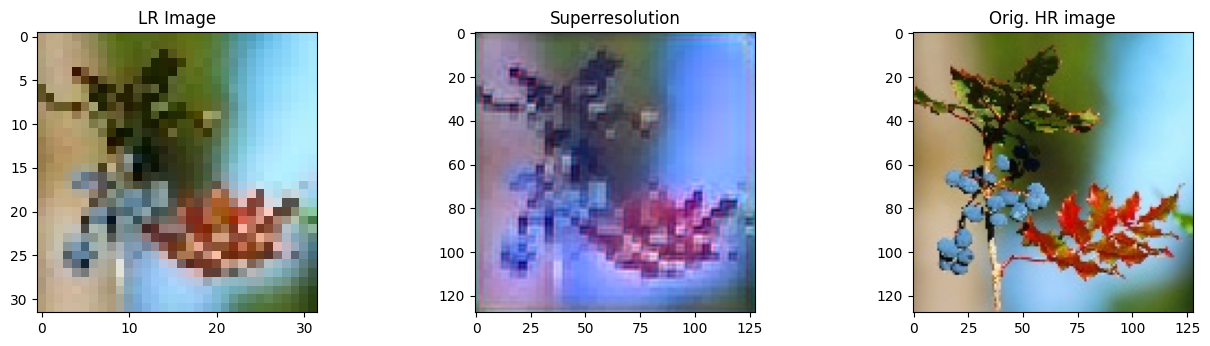

In [27]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/gen_e_5.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()




In [ ]:
################################################
sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting.
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()